# 95891 Introduction to Artificial Intelligence - Group Project
### What To Buy: A Recommendation System for Amazon Based on Co-Purchasing Behavior

**I. Team Members**

David Tsai (chishiut), Judy Tsai (weiyit), Lili Chen (lilichen), Yilin Lyu (yilinlyu), Abigail Zhang (tianaiz)

**II. Project Description**

Our goal is to analyze and leverage the co-purchasing behavior of Amazon customers to make product recommendations and uncover patterns and insights related to product associations. This can help find potential sales boost opportunities and improve customer’s shopping experience.

**III. Our Approach**

We divide our groups into two subteams based on the models we use. The GNN team (David, Judy, and Lili) uses the graph neural network (GNN) model and the ML team (Yilin and Abigail) focuses on machine learning models. The two teams will then work together to analyze the results and decide on the best model to use.

This jupyter notebook contains the code for GNN model training and evaluation.

### 0. Import Libraries and Environment Setup

In [ ]:
! pip install torch_geometric
! pip install dgl -f https://data.dgl.ai/wheels/repo.html
! pip install pyvis
! pip install ogb

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy.sparse as sp
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, MessagePassing
from torch.optim import Adam
from torch_geometric import utils
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.transforms import RandomLinkSplit
from torch.utils.data import DataLoader, Dataset

import dgl
from dgl.nn import SAGEConv
import dgl.function as fn
from dgl.data import DGLDataset
from ogb.nodeproppred import DglNodePropPredDataset

from pyvis.network import Network
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc


import re
import itertools
import pickle

import random
import io
import ast

# To avoid kernel restart due to KMP duplicate library error and DGL backend error
import itertools
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["DGLBACKEND"] = "pytorch"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Data

**1-1 Load Amazon product co-purchasing network dataset**

We imported four datasets of co-purchasing Amazon data, each corresponding to a specific period. Professor Jure Leskovec at Stanford University collected these datasets, which are based on the 'Customers Who Bought This Item Also Bought' feature on the Amazon website.

These text files contain information about products i being co-purchased with product j, represented by a directed edge from i to j in the graph. In this step, we merge these four datasets and save it intp a new file to prepare for later random splitting.

In [ ]:
# load data for each time period
data0302 = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon0302.txt", delimiter='\t', comment='#', header=None)
data0312 = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon0312.txt", delimiter='\t', comment='#', header=None)
data0505 = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon0505.txt", delimiter='\t', comment='#', header=None)
data0601 = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon0601.txt", delimiter='\t', comment='#', header=None)

# Merge 4 datasets into 1
data = pd.concat([data0302, data0312, data0505, data0601])

# Check the first 5 rows
data.head()

**1-2 Load Amazon product co-purchasing network metadata**

We also loaded the metadata for node features. We cleaned it, extracted all the necessary information for future analysis, and outputted it into a DataFrame dataset.

The data was also collected by Professor Jure Leskovec at Stanford University. It contains product metadata and review information about 548,552 different products (Books, music CDs, DVDs and VHS video tapes). This dataset includes information such as Title, Salesrank, List of similar products (that get co-purchased with the current product), Detailed product categorization, and Product reviews: time, customer, rating, number of votes, number of people that found the review helpful.

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/IAI_Project/Data/amazon-meta.txt', delimiter='\t', on_bad_lines = "skip")
metadata.head()

,# Full information about Amazon Share the Love products
0,Total items: 548552
1,f
2,Id: 4
3,ASIN: 0842328327
4,title: Life Application Bible Commentary: 1 ...


### 2. Data Processing

**2-1 Rename Column Name and Change Data Yype for Node Dataset**

After running the four files together, we found that the amount of data was so large that it took several hours to run. So we decided to run a file instead and see if the results performed well as well.

In [ ]:
# For the four concat dataset
data = data.rename(columns={0: 'node_1', 1: 'node_2'})

data['node_1'] = data['node_1'].astype(str)
data['node_1'] = data['node_1'].str.strip()

data['node_2'] = data['node_2'].astype(str)
data['node_2'] = data['node_2'].str.strip()

# For the one dataset 0302
data0302 = data0302.rename(columns={0: 'node_1', 1: 'node_2'})

data0302['node_1'] = data0302['node_1'].astype(str)
data0302['node_1'] = data0302['node_1'].str.strip()

data0302['node_2'] = data0302['node_2'].astype(str)
data0302['node_2'] = data0302['node_2'].str.strip()

# For the one dataset 0312
data0312 = data0312.rename(columns={0: 'node_1', 1: 'node_2'})

data0312['node_1'] = data0312['node_1'].astype(str)
data0312['node_1'] = data0312['node_1'].str.strip()

data0312['node_2'] = data0312['node_2'].astype(str)
data0312['node_2'] = data0312['node_2'].str.strip()

# For the one dataset 0505
data0505 = data0505.rename(columns={0: 'node_1', 1: 'node_2'})

data0505['node_1'] = data0505['node_1'].astype(str)
data0505['node_1'] = data0505['node_1'].str.strip()

data0505['node_2'] = data0505['node_2'].astype(str)
data0505['node_2'] = data0505['node_2'].str.strip()

# For the one dataset 0601
data0601 = data0601.rename(columns={0: 'node_1', 1: 'node_2'})

data0601['node_1'] = data0601['node_1'].astype(str)
data0601['node_1'] = data0601['node_1'].str.strip()

data0601['node_2'] = data0601['node_2'].astype(str)
data0601['node_2'] = data0601['node_2'].str.strip()

In [ ]:
# Save the files
data.to_csv('/content/drive/MyDrive/IAI_Project/Data/amazon_all.txt')
data0302.to_csv('/content/drive/MyDrive/IAI_Project/Data/amazon_0302.txt')
data0312.to_csv('/content/drive/MyDrive/IAI_Project/Data/amazon_0312.txt')
data0505.to_csv('/content/drive/MyDrive/IAI_Project/Data/amazon_0505.txt')
data0601.to_csv('/content/drive/MyDrive/IAI_Project/Data/amazon_0601.txt')

**2-2 Create DataFrame for Metadata**

In [ ]:
# Define the regular expression pattern
pattern = re.compile(r'total:\s*(\d+)\s+downloaded:\s*(\d+)\s+avg rating:\s*([\d.]+)')

# Initialize variables to store extracted data
data_list = []
current_data = {}

# Open and read the file line by line
with open('/content/drive/MyDrive/IAI_Project/Data/amazon-meta.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line.startswith("Id:"):
            if current_data:
                data_list.append(current_data)
            current_data = {'Id': line.split(": ")[1]}
        elif line.startswith("ASIN:"):
            current_data['ASIN'] = line.split(": ")[1]
        elif line.startswith("group:"):
            current_data['Group'] = line.split(": ")[1]
        elif line.startswith("salesrank:"):
            current_data['Salesrank'] = line.split(": ")[1]
        elif line.startswith("title:"):
            current_data['Title'] = line[len("title: "):]
        elif line.startswith("|"):
            current_data.setdefault('Categories_Hierarchy', []).append(line)
        elif line.startswith("similar: "):
            current_data.setdefault('Similar_Products', []).extend(line.split()[2:])
            current_data['Similar_Count'] = line.split()[1]
        elif line.startswith("categories: "):
            current_data['Categories'] = line.split()[1]
        elif line.startswith("reviews: "):
            match = pattern.search(line)
            if match:
                current_data['Total_Reviews'] = int(match.group(1))
                current_data['Downloaded_Reviews'] = int(match.group(2))
                current_data['Average_Rating'] = float(match.group(3))
        elif "cutomer:" in line:
            current_data.setdefault('All_Reviews', []).append(line)
        elif "discontinued product" in line:
            current_data['Is_Discontinued_Product'] = True

# Append the last extracted data
if current_data:
    data_list.append(current_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)


# Display the resulting DataFrame
df.tail()

,Id,ASIN,Title,Group,Salesrank,Similar_Products,Similar_Count,Categories,Categories_Hierarchy,Total_Reviews,Downloaded_Reviews,Average_Rating,All_Reviews,Is_Discontinued_Product
548543,548547,B000059TOC,The Drifter,DVD,0,"[630366704X, B0002ERXB8, B0001932ZU, B0001VTPU...",5,14,[|[139452]|DVD[130]|Genres[404276]|Drama[16337...,1.0,1.0,5.0,[2004-7-22 cutomer: A32PCPZL40G5N8 rating: 5...,NaN
548544,548548,B00006JBIX,The House Of Morecock,DVD,0,"[B0002HOE6C, B0002I84JO, B00004WZQN, B00069CQ8...",5,6,[|[139452]|DVD[130]|Genres[404276]|Art House &...,8.0,5.0,3.0,[2005-2-18 cutomer: A24IFZUH8NLISK rating: 1...,NaN
548545,548549,0879736836,Catholic Bioethics and the Gift of Human Life,Book,0,"[1931709920, 188187110X, 081890643X, 158051046...",5,3,[|Books[283155]|Subjects[1000]|Nonfiction[53]|...,1.0,1.0,4.0,[2003-7-5 cutomer: A2PD80S1N7920J rating: 4 ...,NaN
548546,548550,B00008DDST,"1, 2, 3 Soleils: Taha, Khaled, Faudel",DVD,0,"[B00012FWNC, B0002UNQQI, B00069FKLO, B0000CNTH...",5,3,[|[139452]|DVD[130]|Genres[404276]|Music Video...,3.0,3.0,5.0,[2003-12-31 cutomer: A3NKS7CVEJVTQ6 rating: ...,NaN
548547,548551,B00005MHUG,That Travelin' Two-Beat/Sings the Great Countr...,Music,0,"[B00008OETQ, B00005O6KL, B00006RY87, B0002OTI9...",5,6,[|Music[5174]|Styles[301668]|Miscellaneous[35]...,1.0,1.0,5.0,[2004-5-31 cutomer: ABTSEEYVYQ52M rating: 5...,NaN


**2-3 Handling missing data**

In [ ]:
# Set 'Is Discontinued Product' to True for rows where it is NaN
df.loc[df['Is_Discontinued_Product'].isna(), 'Is_Discontinued_Product'] = False

**2-4 Extract Categories**

Extract a category hierarchy from a dataset and then separate it into six columns, with each column representing the category with the highest frequency

1. Extract the category hierarchy.
2. Split the hierarchy into six columns.
3. In each column, place the category with the highest frequency at that position

In [ ]:
def extract_and_split(categories_hierarchy):
    # print(categories_hierarchy)
    if isinstance(categories_hierarchy, list) and len(categories_hierarchy) > 0:
        category_frequency = {}  # Initialize the dictionary to store category frequencies
        for position in range(1, 7):
            # Extract the category at the specified position for each element in categories_hierarchy
            categories_at_position = [element.split('|')[position] if len(element.split('|')) > position else None for element in categories_hierarchy]
            # print(categories_at_position)
            # Count the frequency of each category
            frequency_count = pd.Series(categories_at_position).value_counts()
            # print(frequency_count)

            # Get the most frequent category
            if not frequency_count.empty:
                most_frequent_category = frequency_count.idxmax()
            else:
                # Handle the empty case, e.g., set to None or perform some other action
                most_frequent_category = None

            # Store the most frequent category in the dictionary
            category_frequency[f'category_{position}'] = most_frequent_category

        return pd.Series(category_frequency)
    else:
        return pd.Series([None, None, None, None, None, None])

new_df = df['Categories_Hierarchy'].apply(extract_and_split)
columns_to_keep = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6']
df[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6']] = new_df[columns_to_keep]

**2-5 Category Grouping**

Add an additional column called 'Main Category' with the most representative from category_1 to category_6.

In [ ]:
df.groupby('Group')['category_4'].value_counts()


In [ ]:
# Define conditions and corresponding values for Main_Category
conditions = [
    (df['Group'] == 'Music') | (df['Group'] == 'Other'),
    (df['Group'] == 'DVD') | (df['Group'] == 'Video') | (df['Group'] == 'Book')
]

values = [
    df['category_3'],
    df['category_4']
]

# Default value if none of the conditions are met
default_value = None

# Use numpy.select to set Main_Category based on conditions
df['Main_Category'] = np.select(conditions, values, default=default_value)

In [ ]:
df['Id'] = df['Id'].str.strip()
df.to_csv('/content/drive/MyDrive/IAI_Project/Data/metadata_cleaned_lili_111723.csv')

### 3. Exploratory Data Analysis

**3-1 Exploring Data Dominance**

Book products constitute 71% of the total, while Music products make up nearly 20%. Books play a predominant role in model training, representing the majority of the raw data.

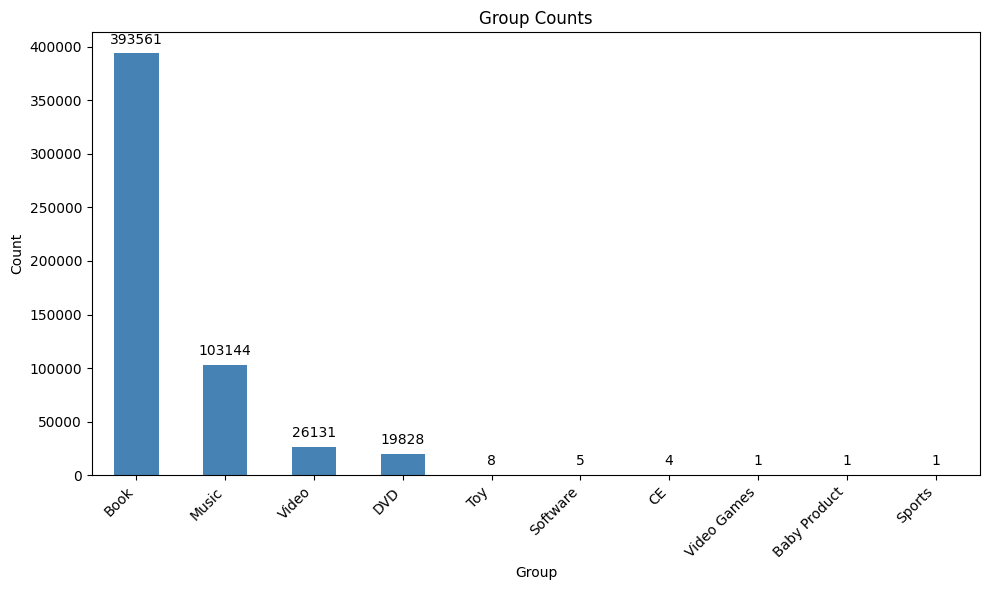

In [ ]:
import matplotlib.pyplot as plt

df_eda = df['Group'].value_counts()

# Plot the data
ax = df_eda.plot(kind='bar', figsize=(10, 6), color='steelblue')
plt.title('Group Counts')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

**3-2 Discontinued Products percentage**

The discontinued product accounts for about 1% of the total data, specifically 1.06% (5868 out of 548,522).

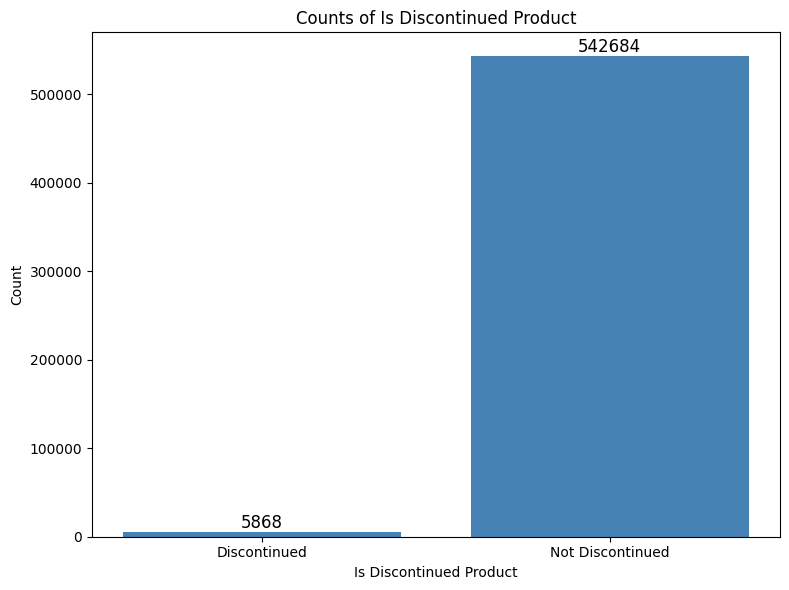

In [ ]:
df_eda = df.groupby(['Is_Discontinued_Product'], dropna=False).size().sort_values(ascending=False)
discontinued_counts = [5868, 542684]
labels = ['Discontinued', 'Not Discontinued']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, discontinued_counts, color='steelblue')
plt.title('Counts of Is Discontinued Product')
plt.xlabel('Is Discontinued Product')
plt.ylabel('Count')

# Add labels on top of the bars
for i, count in enumerate(discontinued_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

**3-3 Add 'Other' type in group**

To improve the clarity of data visualization, eliminate discontinued data and consolidate counts below 10 into a group labeled 'Other.

In [ ]:
df = df.loc[df['Is_Discontinued_Product'] == False, :]
df['Salesrank'] = df['Salesrank'].astype(int)
df['Similar_Count'] = df['Similar_Count'].astype(int)
df['Categories'] = df['Categories'].astype(int)
# Count the occurrences of each group
group_counts = df['Group'].value_counts()

# Find groups with counts less than 10
other_groups = group_counts[group_counts < 10].index

# Replace those groups with 'Other'
df['Group'] = df['Group'].apply(lambda x: 'Other' if x in other_groups else x)
df.groupby(['Group'], dropna=False).size()

Group
Book     393561
DVD       19828
Music    103144
Other        20
Video     26131
dtype: int64

**3-4 Bar plot: Top 10 Main Categories Analysis in each group**

Below graphs provide a comprehensive view of item distribution across different categories within various groups, highlighting potentially influential variables for further analysis. For example, in the Book category, categories such as Christianity and Business & Investing Books stand out with substantial item counts, suggesting their significance.

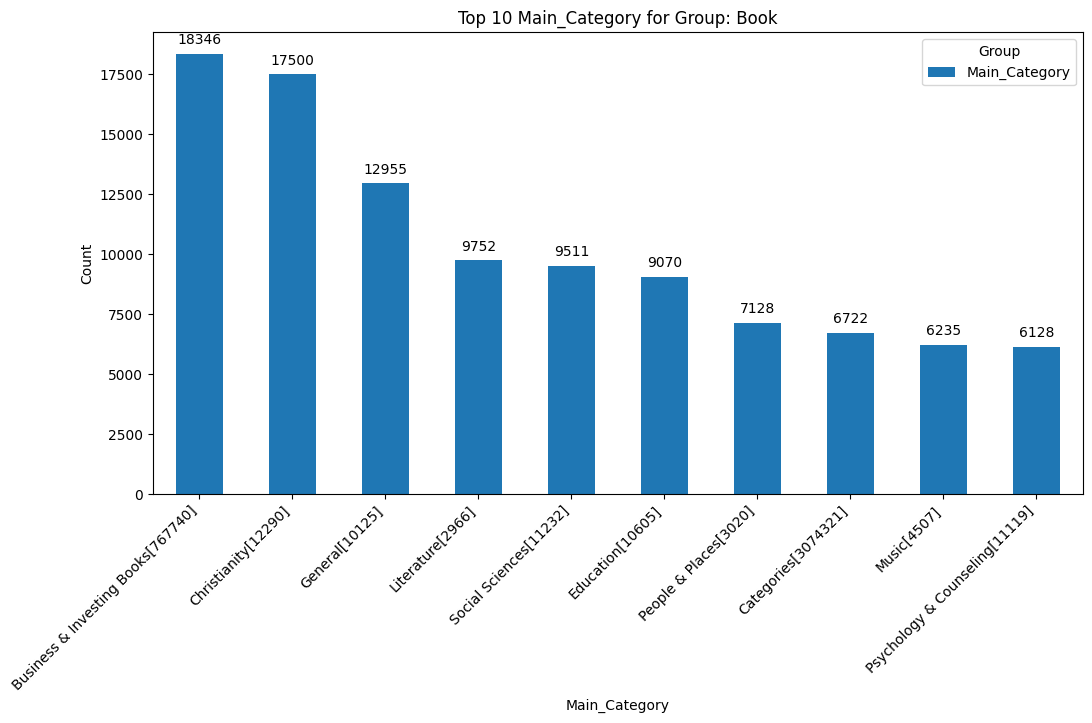

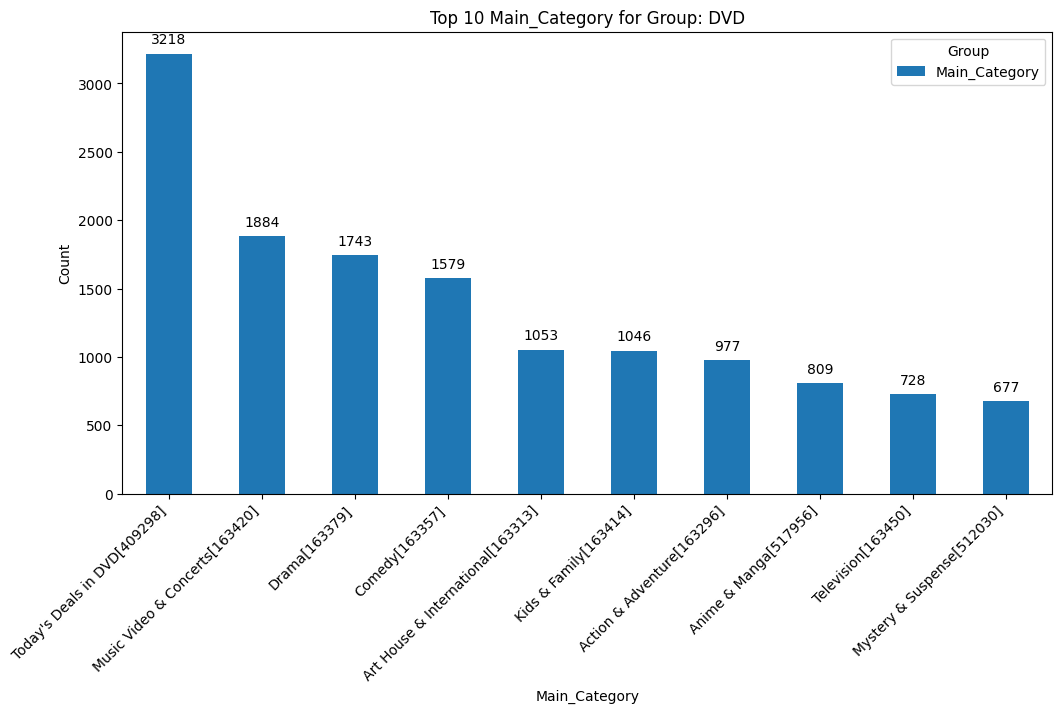

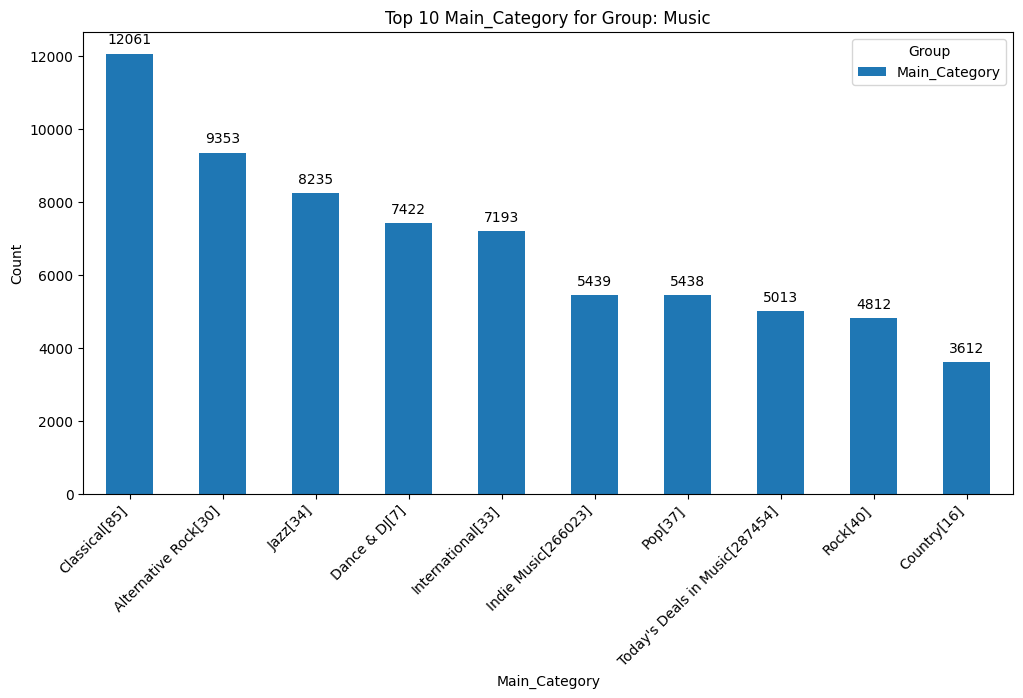

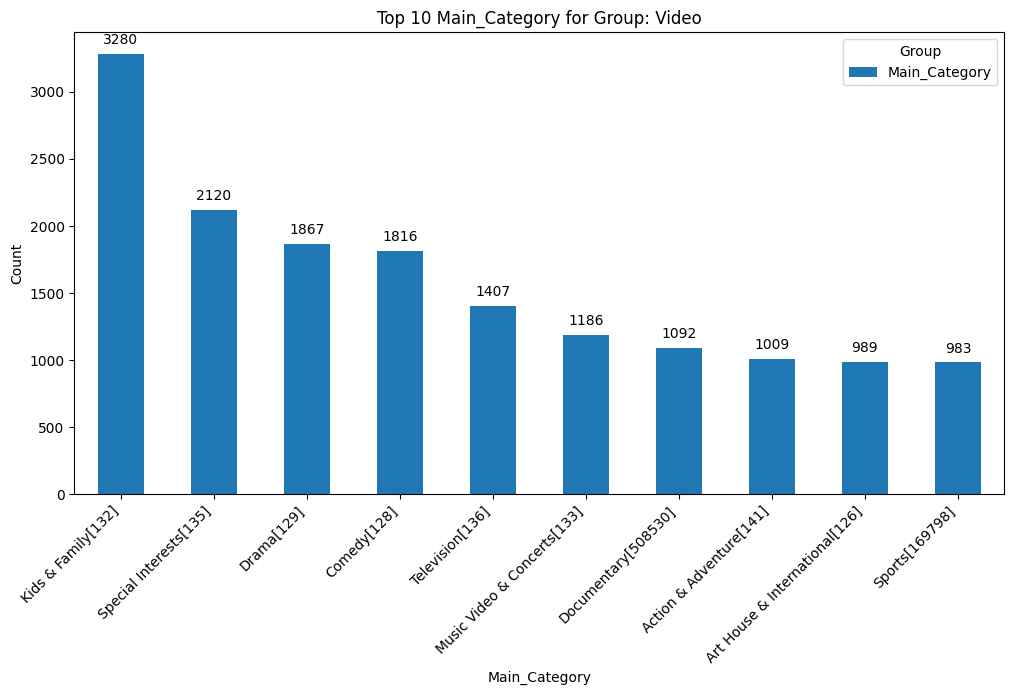

In [ ]:
# Unstack the data to prepare for plotting
grouped_data = df.groupby(['Group', 'Main_Category'])['Main_Category'].count().sort_values(ascending=False)

# Get the top 10 categories in each group
top_categories = grouped_data.groupby('Group').head(10)

# Plot only the top 10 categories in each group
for group_name, group_data in top_categories.groupby(level=0):

    plt.figure(figsize=(12, 6))
    ax = group_data.plot(kind='bar', ax=plt.gca())

    # Add count values at the top of each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax.set_xticklabels(group_data.index.get_level_values('Main_Category'), rotation=45, ha='right')  # Adjust the rotation and ha as needed
    plt.title(f'Top 10 Main_Category for Group: {group_name}')
    plt.xlabel('Main_Category')
    plt.ylabel('Count')
    plt.legend(title='Group')
    plt.show()

**3-5 Box Plots for Key Metrics**

The data exhibits diversity in product characteristics, reviews, and rankings.
1. The prevalence of zero values in Similar_Count and Categories may reflect specific product types that differ significantly from others.
2. High variability in Total_Reviews and Downloaded_Reviews highlights the importance of understanding the review landscape for different products.
3. The generally high Average_Rating suggests a positive sentiment among reviewers, potentially influencing consumer trust.
4. The wide range of Salesrank indicates varying levels of popularity, emphasizing the need to explore factors influencing product success in the market.

       Similar_Count     Categories  Total_Reviews  Downloaded_Reviews  \
count  542684.000000  542684.000000  542684.000000       542684.000000   
mean        3.296071       4.624605      14.339818           13.992017   
std         2.287289       4.450647      74.768369           71.908413   
min         0.000000       0.000000       0.000000            0.000000   
25%         0.000000       2.000000       0.000000            0.000000   
50%         5.000000       4.000000       2.000000            2.000000   
75%         5.000000       6.000000       8.000000            7.000000   
max         5.000000     116.000000    5545.000000         4995.000000   

       Average_Rating     Salesrank  
count   542684.000000  5.426840e+05  
mean         3.209534  4.893243e+05  
std          1.996296  5.677230e+05  
min          0.000000 -1.000000e+00  
25%          0.000000  9.074100e+04  
50%          4.000000  3.004900e+05  
75%          5.000000  6.720688e+05  
max          5.000000  3.7983

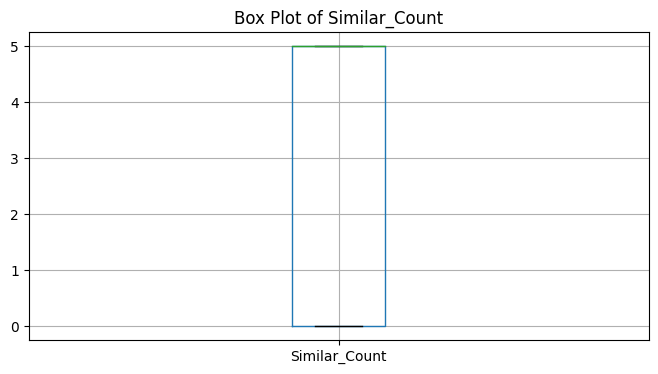

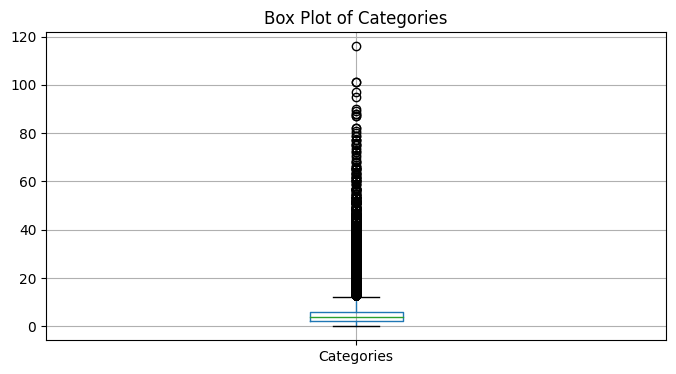

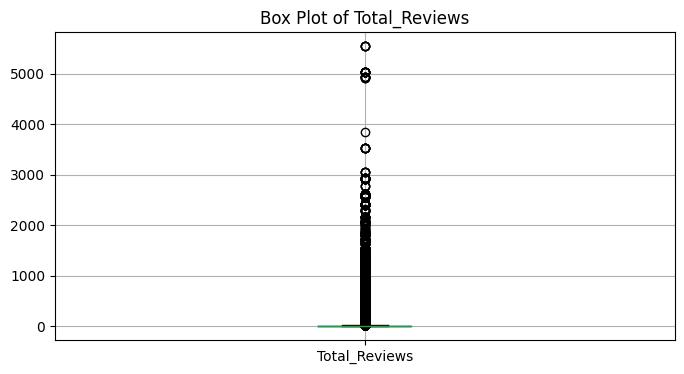

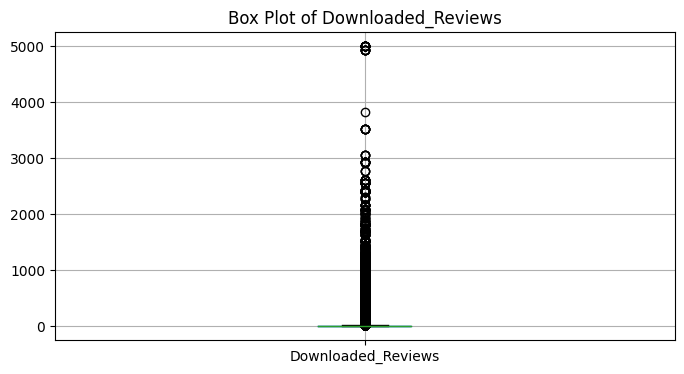

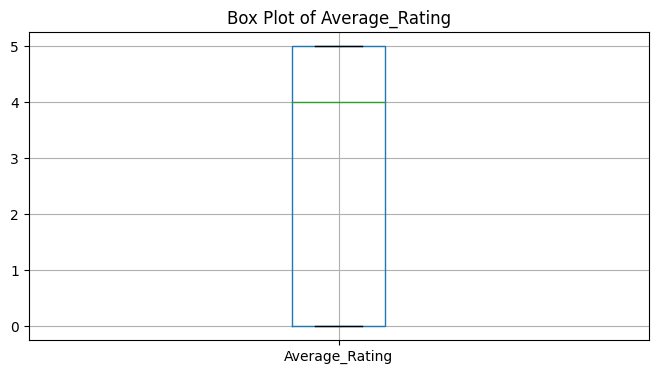

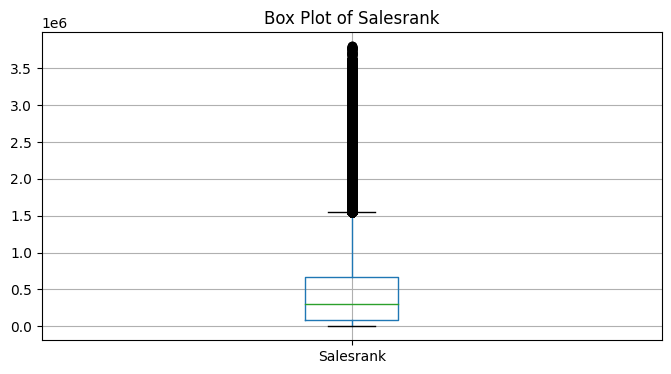

In [ ]:
# Summary Statistics
numerical_cols = ['Similar_Count', 'Categories', 'Total_Reviews', 'Downloaded_Reviews', 'Average_Rating', 'Salesrank']
print(df[numerical_cols].describe())

# Create separate box plots for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    df[[col]].boxplot()
    plt.title(f'Box Plot of {col}')
    plt.show()

**3-6 Bar Plot: Average Metrics by Group & Box Plot: Distribution of Metrics by Group**

1. DVDs:
Similar count of items: DVDs exhibit a more consistent or similar number of items compared to other groups. This suggests a relative stability in the supply or demand for DVDs.
2. Music Products:
Higher average ratings: Products in the music category tend to receive superior average ratings in comparison to other groups. This implies a higher level of customer satisfaction with music products.
3. Books:
Lower sales rank: Books have a lower sales rank in contrast to other product groups. This indicates that, within the marketplace or context being considered, books may not sell as rapidly or attain as high a sales volume as products in other categories.

<Figure size 800x400 with 0 Axes>

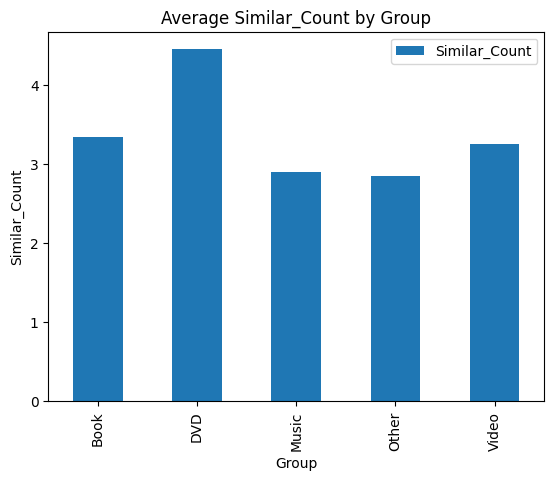

<Figure size 800x400 with 0 Axes>

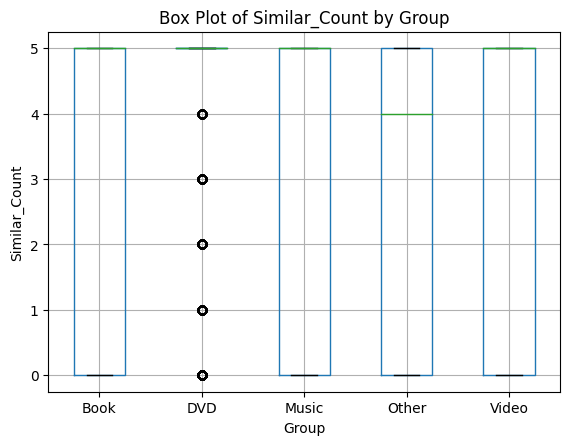

<Figure size 800x400 with 0 Axes>

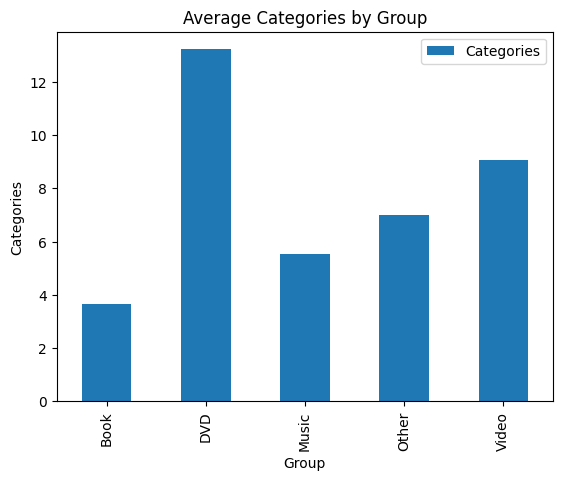

<Figure size 800x400 with 0 Axes>

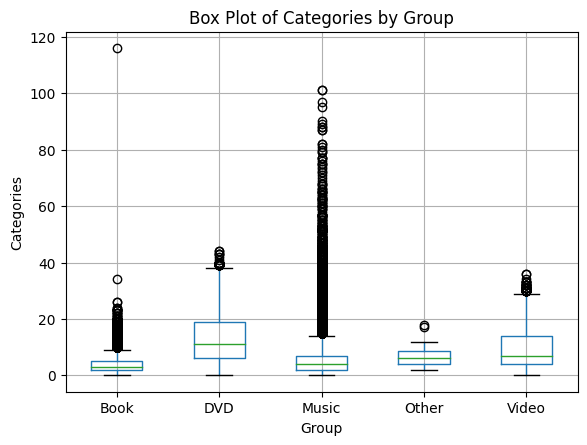

<Figure size 800x400 with 0 Axes>

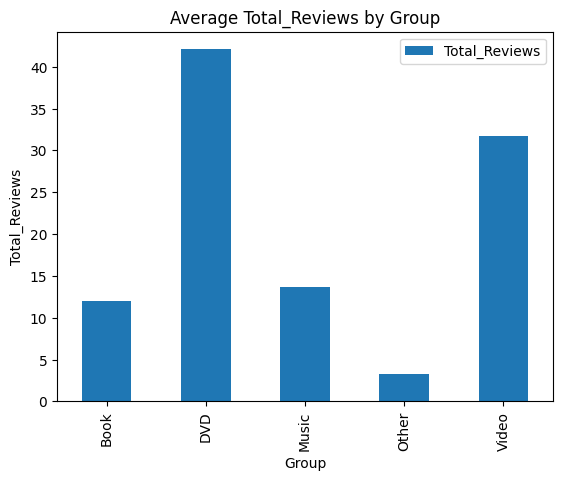

<Figure size 800x400 with 0 Axes>

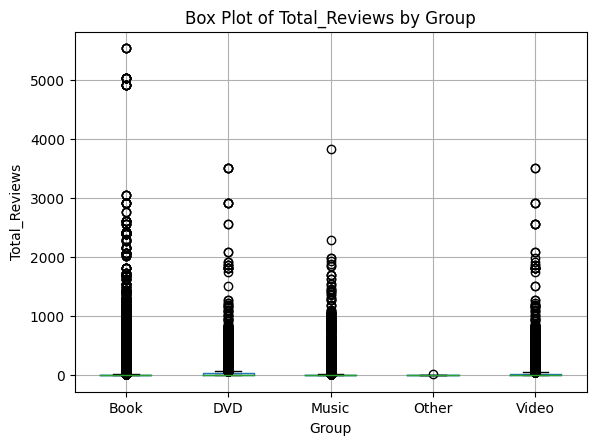

<Figure size 800x400 with 0 Axes>

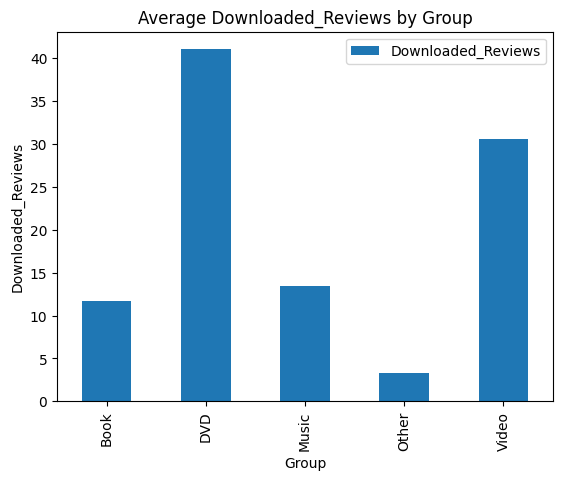

<Figure size 800x400 with 0 Axes>

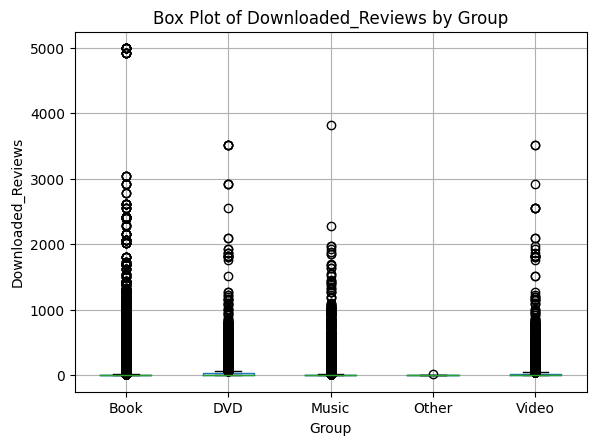

<Figure size 800x400 with 0 Axes>

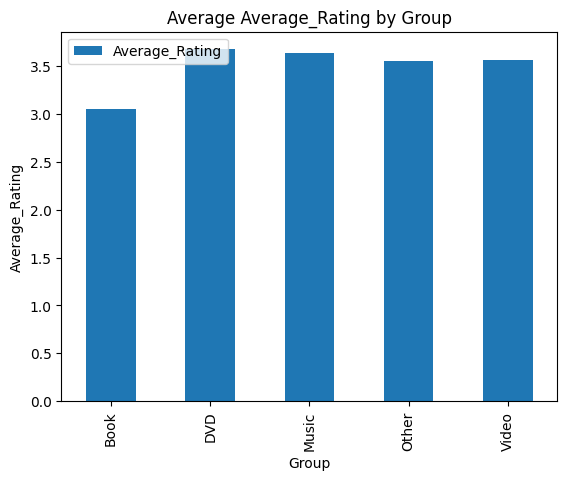

<Figure size 800x400 with 0 Axes>

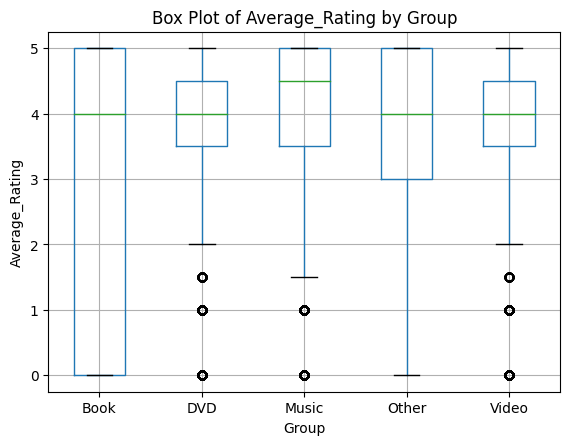

<Figure size 800x400 with 0 Axes>

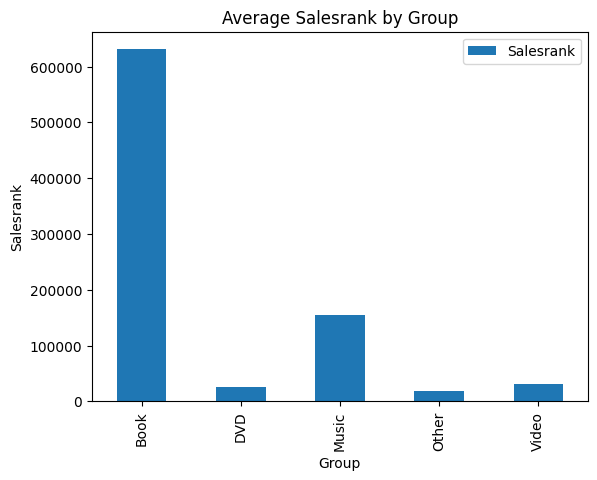

<Figure size 800x400 with 0 Axes>

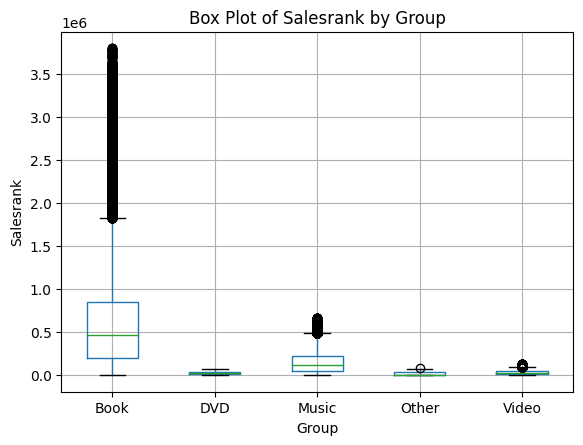

In [ ]:
# Group by 'Group' and create separate graphs for different columns
grouped = df.groupby('Group')
# Create separate box plots for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    grouped[[col]].mean().plot(kind='bar', title=f'Average {col} by Group')
    plt.xlabel('Group')
    plt.ylabel(f'{col}')
    plt.show()

    plt.figure(figsize=(8, 4))
    df.boxplot(column=f'{col}', by='Group')
    plt.title(f'Box Plot of {col} by Group')
    plt.xlabel('Group')
    plt.ylabel(f'{col}')
    plt.suptitle('')  # Remove the default title
    plt.show()

**3-7 Network graph**

Select the amazon0312 dataset as a representative sample for visualization to simplify the analysis.

In [ ]:
data0312 = data0312.rename(columns={0: 'node_1', 1: 'node_2'})

data0312['node_1'] = data0312['node_1'].astype(str)
data0312['node_1'] = data0312['node_1'].str.strip()

data0312['node_2'] = data0312['node_2'].astype(str)
data0312['node_2'] = data0312['node_2'].str.strip()

In [ ]:
# combined_df = data0302.rename(columns={'node_1': 'Source', 'node_2': 'Target'})
combined_df = data0312.rename(columns={'node_1': 'Source', 'node_2': 'Target'})
combined_df['Source'] = combined_df['Source'].astype(int)
combined_df['Target'] = combined_df['Target'].astype(int)
meta_df = combined_df.merge(df, left_on='Source', right_on='Id', how='left')
df['Id'] = df['Id'].astype(str).str.strip()
df['Id'] = df['Id'].astype(int)
meta_df.dropna(subset=['Is_Discontinued_Product'], inplace=True)

In [ ]:
# Identify rows in combined_df where both 'Source' and 'Target' are not in meta_df's 'Id'
mask = combined_df['Source'].isin(df['Id']) & combined_df['Target'].isin(df['Id'])

# Filter combined_df based on the mask
filtered_combined_df = combined_df[mask]

**3-7a Network graph**

Upon observing the initial 20 nodes, two distinct clusters emerge. The first cluster encompasses connections related to books, while the second cluster further divides into two subclusters. Notably, when a customer purchases items within the "earth-based religions books" category (ID 2), they are likely to also buy books with IDs 11, 12, and 14, along with item 14 from the history music category.

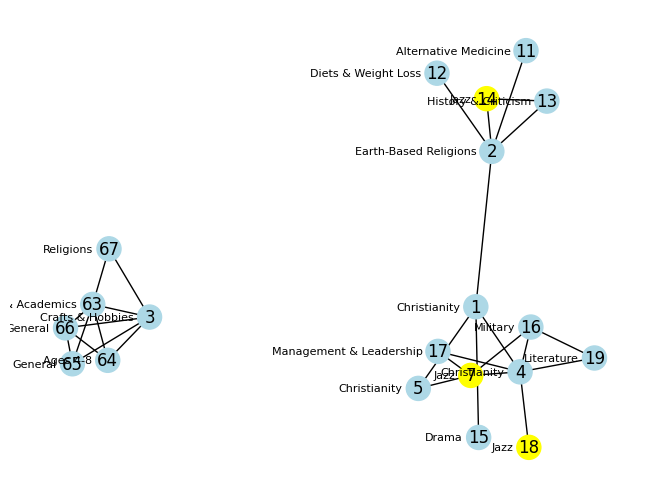

In [ ]:
# Assuming 'combined_df' is your DataFrame containing the edges information
# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(filtered_combined_df, source='Source', target='Target')

# Keep 20 nodes
num_nodes_to_keep = 20

# Node sampling: Keep a random subset of nodes
nodes_to_keep = list(G.nodes())[:num_nodes_to_keep]

# Create the down-sampled graph
downsampled_graph = G.subgraph(nodes_to_keep)

# Create a mapping from 'Group' to colors
group_colors = {
    'Book': 'lightblue',
    'DVD': 'green',
    'Music': 'yellow',
    'Video': 'red',
    'Other': 'orange'
}

# Assign colors to nodes based on their 'Group'
node_colors = []

for node in downsampled_graph.nodes:
    if node in df.index:
        group = df.loc[node]['Group']
        color = group_colors.get(group, 'gray')  # Use 'gray' for unknown groups
        node_colors.append(color)
    else:
        # Handle the case when a node doesn't have a 'Group' attribute in 'df'
        node_colors.append('gray')

# Plot the down-sampled graph with node colors
pos = nx.spring_layout(downsampled_graph, k=0.5)  # You can use different layouts

nx.draw(downsampled_graph, pos, node_color=node_colors, with_labels=True)

# Create a dictionary to map nodes to their 'category' from the 'df' DataFrame
node_category = {node: df.loc[node]['Main_Category'].split("[")[0] for node in downsampled_graph.nodes if node in df.index}

# Adjust the position of labels to the left of nodes
label_positions = {node: (pos[node][0] - 0.05, pos[node][1]) for node in downsampled_graph.nodes if node in node_category}

# Add 'Main_Category' labels to the left of the nodes
nx.draw_networkx_labels(downsampled_graph, label_positions, node_category, font_size=8, horizontalalignment='right')

plt.show()

**3-7b GNN graph**

Upon analyzing the top 40 nodes, it became evident that customers who acquire items in the "earth-based religions books" category (ID 2) and item 12 are likely to also purchase books with IDs 260-263. Additionally, a significant connection exists between nodes 30 and 67, indicating that node 30 serves as a key link to node 67 in the network.

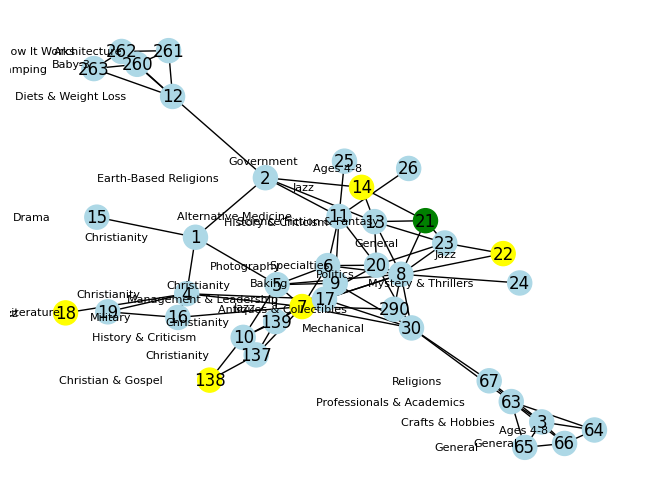

In [ ]:


# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(filtered_combined_df, source='Source', target='Target')

# Keep 40 nodes
num_nodes_to_keep = 40

# Node sampling: Keep a random subset of nodes
nodes_to_keep = list(G.nodes())[:num_nodes_to_keep]

# Create the down-sampled graph
downsampled_graph = G.subgraph(nodes_to_keep)

# Create a mapping from 'Group' to colors
group_colors = {
    'Book': 'lightblue',
    'DVD': 'green',
    'Music': 'yellow',
    'Video': 'red',
    'Other': 'orange'
}

# Assign colors to nodes based on their 'Group'
node_colors = []

for node in downsampled_graph.nodes:
    if node in df.index:
        group = df.loc[node]['Group']
        color = group_colors.get(group, 'gray')  # Use 'gray' for unknown groups
        node_colors.append(color)
    else:
        # Handle the case when a node doesn't have a 'Group' attribute in 'df'
        node_colors.append('gray')

# Plot the down-sampled graph with node colors
pos = nx.spring_layout(downsampled_graph)  # You can use different layouts
nx.draw(downsampled_graph, pos, node_color=node_colors, with_labels=True)

# Create a dictionary to map nodes to their 'category' from the 'df' DataFrame
node_category = {node: df.loc[node]['Main_Category'].split("[")[0] for node in downsampled_graph.nodes if node in df.index}

# Adjust the position of labels to the left of nodes
label_positions = {node: (pos[node][0] - 0.1, pos[node][1]) for node in downsampled_graph.nodes if node in node_category}

# Add 'Main_Category' labels to the left of the nodes
nx.draw_networkx_labels(downsampled_graph, label_positions, node_category, font_size=8, horizontalalignment='right')

plt.show()

### 4. Add features to nodes

**4-1 Load feature data**

In [ ]:
nodes_data = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/metadata_cleaned_lili_111723.csv",
                                 dtype={'Id': 'str'},
                                 usecols = ['Id', 'Salesrank', 'Group', 'Average_Rating', 'Main_Category'])
nodes_data = nodes_data.dropna()
nodes_data

,Id,Group,Salesrank,Average_Rating,Main_Category
1,1,Book,396585.0,5.0,Christianity[12290]
2,2,Book,168596.0,4.5,Earth-Based Religions[12472]
3,3,Book,1270652.0,5.0,Crafts & Hobbies[5126]
4,4,Book,631289.0,4.0,Christianity[12290]
5,5,Book,455160.0,0.0,Christianity[12290]
...,...,...,...,...,...
548547,548547,DVD,0.0,5.0,Today's Deals in DVD[409298]
548548,548548,DVD,0.0,3.0,Independently Distributed[901596]
548549,548549,Book,0.0,4.0,Social Sciences[11232]
548550,548550,DVD,0.0,5.0,Music Video & Concerts[163420]


### 5. GNN Model

**Build GNN Model**

Overall approach: We train model with and without node features for each time period at a time, resutling in a total of 10 models.

## 5-1 WIthout Node Features and Labels

In [ ]:
class AmazonDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="amazon_copurchasing")

    def process(self):
        edges_data = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon_0601.txt")

        edges_src = torch.from_numpy(edges_data['node_1'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['node_2'].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        # No node features and labels assigned

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1


dataset = AmazonDataset()
dataset.process()
graph = dataset[0]

print(graph)


Graph(num_nodes=516881, num_edges=1234877,
      ndata_schemes={}
      edata_schemes={})


In [ ]:
# Without Feature
# Split edge set for training and testing
u, v = graph.edges()

eids = np.arange(graph.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = graph.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Create train and test graphs without node features and labels
train_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=graph.num_nodes())
test_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=graph.num_nodes())

print("Node Data Keys (Train Graph):", train_g.ndata.keys())
print("Node Data Keys (Test Graph):", test_g.ndata.keys())


Node Data Keys (Train Graph): dict_keys([])
Node Data Keys (Test Graph): dict_keys([])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, out_feats, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.sage = SAGEConv(in_feats, out_feats, 'mean')
        self.fc = nn.Linear(out_feats, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g):
        in_feat = torch.ones(g.num_nodes(), 1).to(device)  # Provide a dummy feature
        in_feat = self.dropout(in_feat)
        return self.fc(self.sage(g, in_feat))

In [ ]:
# Define DotPredictor and loss functions
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge, so you need to squeeze it.
            return g.edata["score"][:, 0]

In [ ]:
model = GraphSAGE(in_feats=2, out_feats=15, dropout=0.5)

In [ ]:
# pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
# Define a function to generate negative edges
def generate_negative_edges(graph, num_neg_samples):
    edges = graph.edges()
    permuted_idx = np.random.permutation(graph.num_edges())
    neg_edges_src = edges[0][permuted_idx[:num_neg_samples]]
    neg_edges_dst = edges[1][permuted_idx[:num_neg_samples]]
    return neg_edges_src, neg_edges_dst

In epoch 0, loss: 0.5424014329910278
In epoch 5, loss: 0.5381229519844055
In epoch 10, loss: 0.5337165594100952
In epoch 15, loss: 0.5296230912208557
AUC 0.5076536072623029


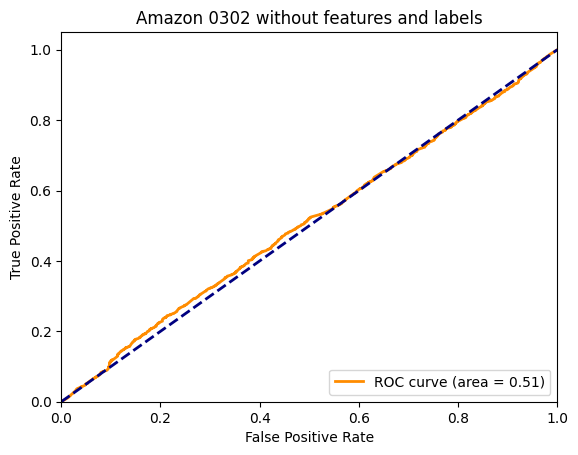

AUC 0.5076536072623029


In [ ]:
# 0302 without features and labels

# Instantiate the GraphSAGE model
in_feats = 1  # Modify this based on the actual number of input features
out_feats = 15
dropout = 0.5
model = GraphSAGE(in_feats, out_feats, dropout).to(device)

# Assuming no node features (graph.ndata["feat"]) in this case
graph = dgl.graph((u, v), num_nodes=graph.num_nodes())

# Set a seed for reproducibility
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph)  # Pass None for node features
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0302 without features and labels")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)


In epoch 0, loss: 0.6421870589256287
In epoch 5, loss: 0.639398992061615
In epoch 10, loss: 0.6360812783241272
In epoch 15, loss: 0.6325251460075378
AUC 0.5053885834136387


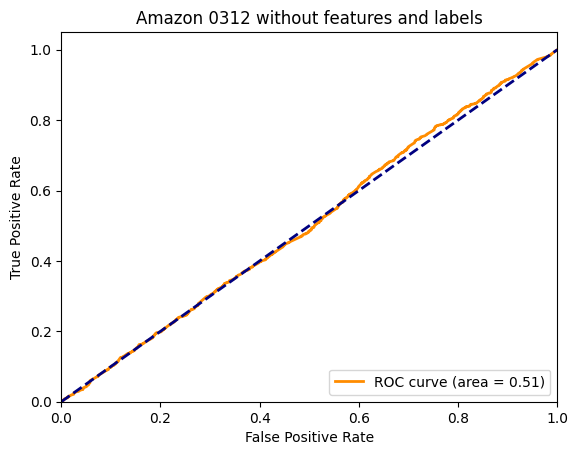

AUC 0.5053885834136387


In [ ]:
# 0312 without features and labels

# Instantiate the GraphSAGE model
in_feats = 1  # Modify this based on the actual number of input features
out_feats = 15
dropout = 0.5
model = GraphSAGE(in_feats, out_feats, dropout).to(device)

# Assuming no node features (graph.ndata["feat"]) in this case
graph = dgl.graph((u, v), num_nodes=graph.num_nodes())

# Set a seed for reproducibility
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph)  # Pass None for node features
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0312 without features and labels")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 0.7711308598518372
In epoch 5, loss: 0.7696011662483215
In epoch 10, loss: 0.7681540846824646
In epoch 15, loss: 0.7664061188697815
AUC 0.5210499971656936


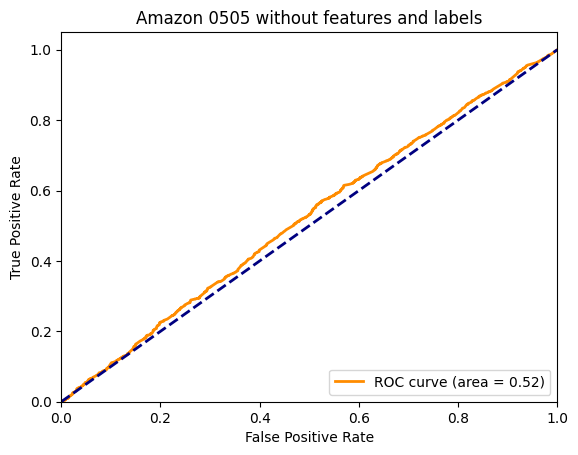

AUC 0.5210499971656936


In [ ]:
# 0505 without features and labels

# Instantiate the GraphSAGE model
in_feats = 1  # Modify this based on the actual number of input features
out_feats = 15
dropout = 0.5
model = GraphSAGE(in_feats, out_feats, dropout).to(device)

# Assuming no node features (graph.ndata["feat"]) in this case
graph = dgl.graph((u, v), num_nodes=graph.num_nodes())

# Set a seed for reproducibility
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph)  # Pass None for node features
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0505 without features and labels")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 0.6421870589256287
In epoch 5, loss: 0.639398992061615
In epoch 10, loss: 0.6360812783241272
In epoch 15, loss: 0.6325251460075378
AUC 0.5036368443641841


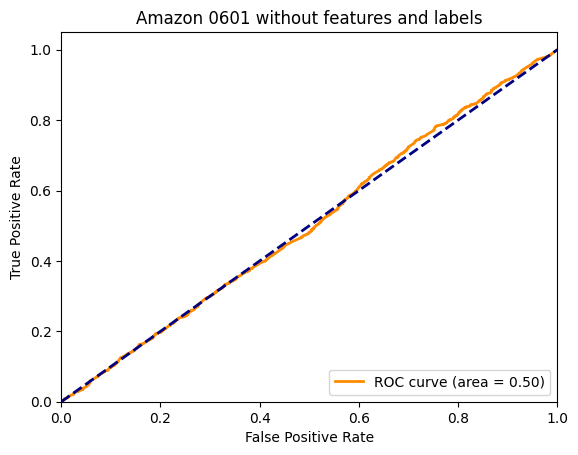

AUC 0.5036368443641841


In [ ]:
# 0601 without features and labels

# Instantiate the GraphSAGE model
in_feats = 1  # Modify this based on the actual number of input features
out_feats = 15
dropout = 0.5
model = GraphSAGE(in_feats, out_feats, dropout).to(device)

# Assuming you don't have node features (graph.ndata["feat"]) in this case
graph = dgl.graph((u, v), num_nodes=graph.num_nodes())

# Set a seed for reproducibility
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph)  # Pass None for node features
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0601 without features and labels")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 0.6464081406593323
In epoch 5, loss: 0.6440728306770325
In epoch 10, loss: 0.6417147517204285
In epoch 15, loss: 0.6392428278923035
AUC 0.49929814517975724


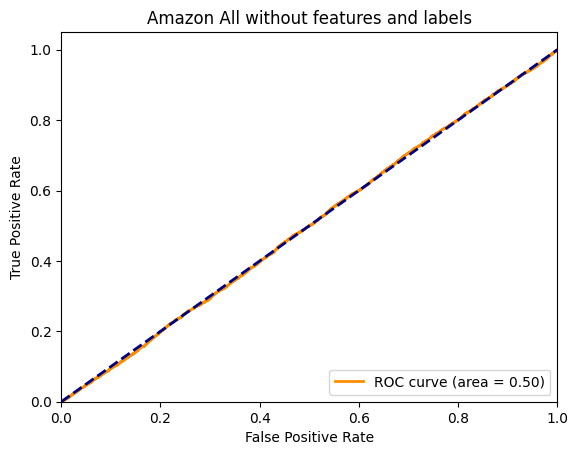

AUC 0.49929814517975724


In [ ]:
# All without features and labels

# Instantiate the GraphSAGE model
in_feats = 1  # Modify this based on the actual number of input features
out_feats = 15
dropout = 0.5
model = GraphSAGE(in_feats, out_feats, dropout).to(device)

# Assuming you don't have node features (graph.ndata["feat"]) in this case
graph = dgl.graph((u, v), num_nodes=graph.num_nodes())

# Set a seed for reproducibility
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph)  # Pass None for node features
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=4000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=4000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon All without features and labels")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

Apparently, the models do not perform well without node features.

## 5-2 With Node Features and Labels

In [ ]:
# With Feature
class AmazonDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="amazon_copurchasing")

    def process(self):
        edges_data = pd.read_csv("/content/drive/MyDrive/IAI_Project/Data/amazon_all.txt")

        node_features = torch.from_numpy(nodes_data[['Salesrank', 'Average_Rating']].to_numpy())
        node_labels = torch.from_numpy(nodes_data["Main_Category"].astype("category").cat.codes.to_numpy())
        new_label = torch.from_numpy(nodes_data["Group"].astype("category").cat.codes.to_numpy())


        edges_src = torch.from_numpy(edges_data['node_1'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['node_2'].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels

        # If a node classification dataset: need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1


dataset = AmazonDataset()
dataset.process()
graph = dataset[0]

print(graph)

Graph(num_nodes=516881, num_edges=11179529,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int16), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [ ]:
# With Feature
# Assuming node features are stored under the key "feat"
graph.ndata["feat"] = graph.ndata["feat"].float()  # Convert to float if necessary

# Split edge set for training and testing
u, v = graph.edges()

eids = np.arange(graph.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = graph.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Create train and test graphs
train_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=graph.num_nodes())
test_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=graph.num_nodes())

# Copy node features to train and test graphs
train_g.ndata["feat"] = graph.ndata["feat"]
test_g.ndata["feat"] = graph.ndata["feat"]

print("Node Data Keys (Train Graph):", train_g.ndata.keys())
print("Node Data Keys (Test Graph):", test_g.ndata.keys())


Node Data Keys (Train Graph): dict_keys(['feat'])
Node Data Keys (Test Graph): dict_keys(['feat'])


In [ ]:
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge, so you need to squeeze it.
            return g.edata["score"][:, 0]

In [ ]:
model = GraphSAGE(train_g.ndata["feat"].shape[1], 15)

In [ ]:
# pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
def generate_negative_edges(graph, num_neg_samples):
    num_nodes = graph.num_nodes()
    existing_edges = set(zip(graph.edges()[0].numpy(), graph.edges()[1].numpy()))

    neg_edges = []
    while len(neg_edges) < num_neg_samples:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        if src != dst and (src, dst) not in existing_edges:
            neg_edges.append((src, dst))

    neg_edges = np.array(neg_edges).T
    return torch.from_numpy(neg_edges[0]), torch.from_numpy(neg_edges[1])


In epoch 0, loss: 2654422016.0
In epoch 5, loss: 2515599616.0
In epoch 10, loss: 2387409152.0
In epoch 15, loss: 2269461760.0
AUC 0.8056052985334489


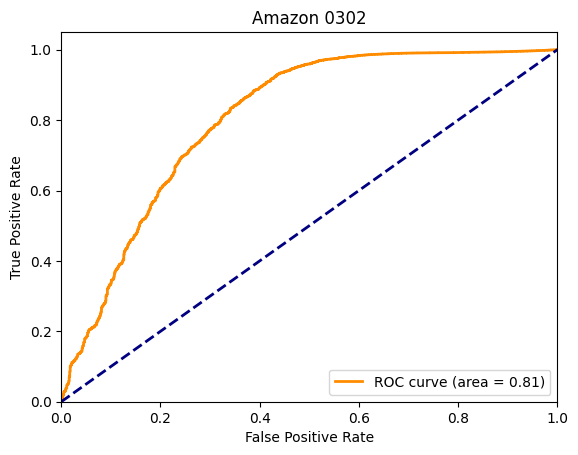

AUC 0.8056052985334489


In [ ]:
# 0302
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

model = model.float()
graph.ndata["feat"] = graph.ndata["feat"].float()

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph, graph.ndata["feat"])
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0302")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)


In epoch 0, loss: 985371264.0
In epoch 5, loss: 974744896.0
In epoch 10, loss: 964290496.0
In epoch 15, loss: 953942720.0
AUC 0.8418779061763586


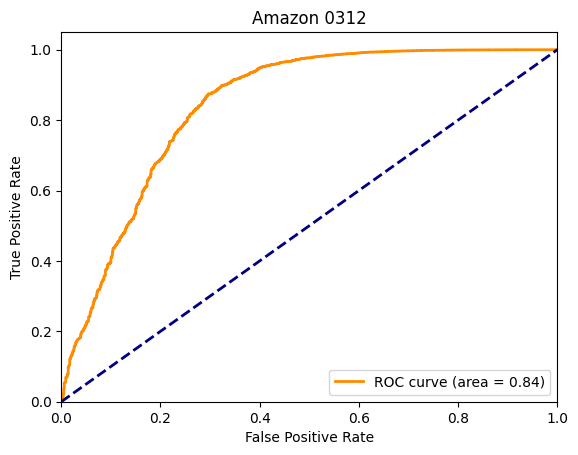

AUC 0.8418779061763586


In [ ]:
# 0312
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

model = model.float()
graph.ndata["feat"] = graph.ndata["feat"].float()

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph, graph.ndata["feat"])
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0312")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 1029123584.0
In epoch 5, loss: 1018000832.0
In epoch 10, loss: 1006980416.0
In epoch 15, loss: 996099136.0
AUC 0.8423986330544916


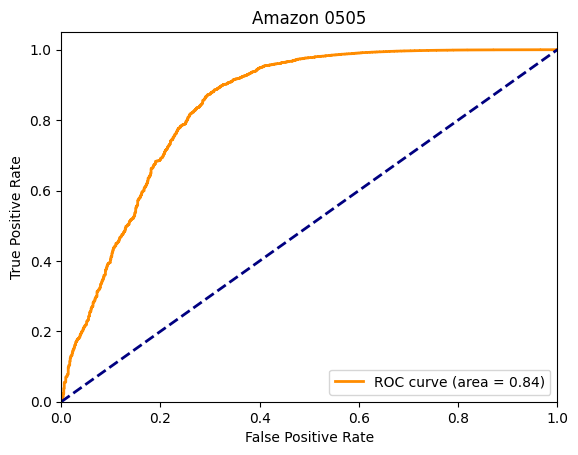

AUC 0.8423986330544916


In [ ]:
# 0505
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

model = model.float()
graph.ndata["feat"] = graph.ndata["feat"].float()

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph, graph.ndata["feat"])
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0505")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 1029123584.0
In epoch 5, loss: 1018000832.0
In epoch 10, loss: 1006980416.0
In epoch 15, loss: 996099136.0
AUC 0.8423986330544916


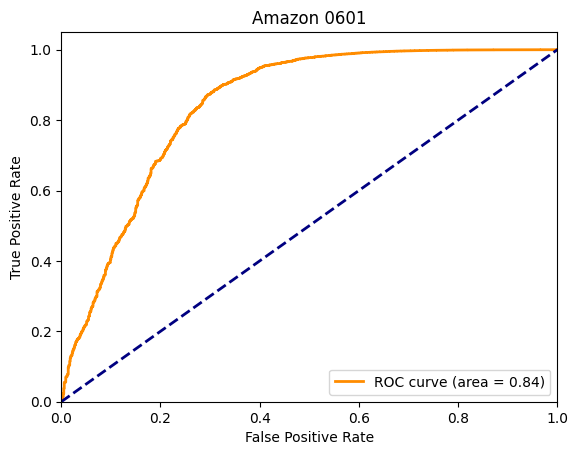

AUC 0.8423986330544916


In [ ]:
# 0601
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

model = model.float()
graph.ndata["feat"] = graph.ndata["feat"].float()

# ----------- training -------------------------------- #
all_logits = []
for e in range(20):
    h = model(graph, graph.ndata["feat"])
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=1000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon 0601")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

In epoch 0, loss: 741665472.0
In epoch 5, loss: 733065344.0
In epoch 10, loss: 724543936.0
In epoch 15, loss: 716106240.0
In epoch 20, loss: 707756160.0
In epoch 25, loss: 699496768.0
In epoch 30, loss: 691330432.0
In epoch 35, loss: 683258112.0
In epoch 40, loss: 675282368.0
In epoch 45, loss: 667406528.0
AUC 0.6759646926925307


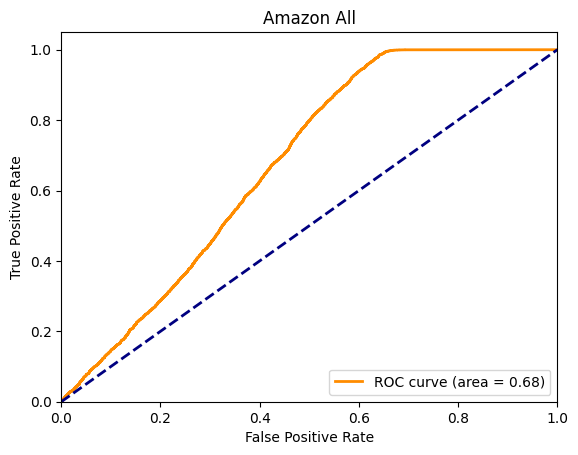

AUC 0.6759646926925307


In [ ]:
# All
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), DotPredictor().parameters()), lr=0.0001
)

model = model.float()
graph.ndata["feat"] = graph.ndata["feat"].float()

# ----------- training -------------------------------- #
all_logits = []
for e in range(50):
    h = model(graph, graph.ndata["feat"])
    pos_score = DotPredictor()(graph, h)

    # Set seed before negative edge sampling
    np.random.seed(seed)
    random.seed(seed)

    # Create negative edges on-the-fly (sampling or other strategy)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=4000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- check results ------------------------ #
with torch.no_grad():
    pos_score = DotPredictor()(test_g, h)
    neg_edges_src, neg_edges_dst = generate_negative_edges(graph, num_neg_samples=4000)
    neg_g = dgl.graph((neg_edges_src, neg_edges_dst), num_nodes=graph.num_nodes())
    neg_score = DotPredictor()(neg_g, h)

    print("AUC", compute_auc(pos_score, neg_score))

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(
        torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy(),
        torch.cat([pos_score, neg_score]).numpy(),
    )

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Amazon All")
    plt.legend(loc="lower right")
    plt.show()

    print("AUC", roc_auc)

# The following code is for our previous approaches.

**5.1 Read node features data**

**5-1 Nodes and Edges Calculation**

We utilized the merged data to create directed graph and calculate the total number of nodes and edges present in the entire graph.

In [ ]:
# # Create directed graphs from the train and test data
# G = nx.from_pandas_edgelist(data, source='node_1', target='node_2', create_using=nx.DiGraph())

# # Add node attributes
# nx.set_node_attributes(G, pd.Series(df.Group, index=df.Id).to_dict(), 'Group')
# nx.set_node_attributes(G, pd.Series(df.Salesrank, index=df.Id).to_dict(), 'Salesrank')
# nx.set_node_attributes(G, pd.Series(df.Average_Rating	, index=df.Id).to_dict(), 'Average_Rating	')
# nx.set_node_attributes(G, pd.Series(df.Main_Category, index=df.Id).to_dict(), 'Main_Category')


# # Print number of nodes and edges
# print("Number of nodes:", G.number_of_nodes())
# print("Number of edges:", G.number_of_edges())

In [ ]:
# Convert nextworkx to dgl data
# g = dgl.from_networkx(G_data)

In [ ]:
# negative_sampler = dgl.dataloading.negative_sampler.Uniform(5)

In [ ]:
# sampler = dgl.dataloading.NeighborSampler([4, 4])
# sampler = dgl.dataloading.as_edge_prediction_sampler(
#     sampler, negative_sampler=negative_sampler
# )
# train_dataloader = dgl.dataloading.DataLoader(
#     # The following arguments are specific to DataLoader.
#     g,  # The graph
#     torch.arange(g.num_edges()),  # The edges to iterate over
#     sampler,  # The neighbor sampler
#     # device=device,  # Put the MFGs on CPU or GPU
#     batch_size=1024,  # Batch size
#     shuffle=True,  # Whether to shuffle the nodes for every epoch
#     drop_last=False,  # Whether to drop the last incomplete batch
#     num_workers=0,  # Number of sampler processes
# )


In [ ]:
# input_nodes, pos_graph, neg_graph, mfgs = next(iter(train_dataloader))
# print("Number of input nodes:", len(input_nodes))
# print("Positive graph # nodes:", pos_graph.num_nodes(),
#     "# edges:", pos_graph.num_edges())
# print("Negative graph # nodes:", neg_graph.num_nodes(),
#     "# edges:", neg_graph.num_edges())
# print(mfgs)

**5-2 Create and save the data into a .pt file for PyG use**

The code below performs several key steps for processing graph data.
We got the number of edges by reading lines from the merged data file and then shuffled these edges to introduce randomness. This step is to randomly split the merged data into training and testing sets. Here, we set 0.7 for training and 0.3 for testing.

For the training data, the function calculates in-degrees for each node, representing how many edges are directed towards a node. These in-degrees are utilized as node features. The training edges are processed and converted into a tensor, capturing the edge indices for the training graph. Similarly, the testing edges are processed, resulting in a tensor representing edge indices for the testing graph.

Both training and testing graphs are organized into a PyTorch Geometric data structure, including node features and edge indices. These processed graphs are then saved as .pt files, making them easily accessible for future use.

In [ ]:
# def graph_to_pt(data, name, train_ratio=0.8):
#     # Assuming 'data' is a PyTorch Geometric Data object
#     num_nodes = data.num_nodes

#     # Assuming 'data' contains edge indices
#     edge_indices = data.edge_index

#     # Assuming 'data' contains node features
#     node_features = data.x

#     # Randomly shuffle the edges
#     indices = torch.randperm(edge_indices.size(1))
#     edge_indices = edge_indices[:, indices]

#     # Calculate the number of edges for the training set
#     num_train_edges = int(edge_indices.size(1) * train_ratio)

#     train_edge_index = edge_indices[:, :num_train_edges]
#     test_edge_index = edge_indices[:, num_train_edges:]

#     # Process training edges
#     in_degrees = torch.zeros((num_nodes,), dtype=torch.float32)
#     in_degrees.scatter_add_(0, train_edge_index[1], torch.ones_like(train_edge_index[1], dtype=torch.float32))

#     train_graph = Data(x=node_features, edge_index=train_edge_index)

#     # Process test edges
#     test_graph = Data(x=node_features, edge_index=test_edge_index)

#     # Save the graphs to .pt files (optional)
#     torch.save(train_graph, f"train_{name}")
#     torch.save(test_graph, f"test_{name}")

#     return train_graph, test_graph

# # Replace 'your_data' with the actual PyTorch Geometric Data object
# train_graph, test_graph = graph_to_pt(data, "graph.pt")

In [ ]:
# # Below is the train and test data look like after splitting.
# print(train_graph)
# print(test_graph)

In [ ]:
# negative_sampler = dgl.dataloading.negative_sampler.Uniform(5)

# sampler = dgl.dataloading.NeighborSampler([4, 4])
# sampler = dgl.dataloading.as_edge_prediction_sampler(sampler, negative_sampler=negative_sampler)
# train_dataloader = dgl.dataloading.DataLoader(
#     G_data,                                  # The graph
#     torch.arange(G_data.number_of_edges()),  # The edges to iterate over
#     sampler,                                # The neighbor sampler
#     batch_size=1024,    # Batch size
#     shuffle=True,       # Whether to shuffle the nodes for every epoch
#     drop_last=False,    # Whether to drop the last incomplete batch
#     num_workers=0       # Number of sampler processes
# )

In [ ]:
# input_nodes, pos_graph, neg_graph, mfgs = next(iter(train_dataloader))
# print('Number of input nodes:', len(input_nodes))
# print('Positive graph # nodes:', pos_graph.number_of_nodes(), '# edges:', pos_graph.number_of_edges())
# print('Negative graph # nodes:', neg_graph.number_of_nodes(), '# edges:', neg_graph.number_of_edges())
# print(mfgs)

**5-3 Downsampling**

As the dataset we are working is huge, therefore, we decide to perform downsampling on our train graph, which means reducing the number of nodes in the graph while preserving its structural and connectivity characteristics. This process is crucial for large-scale graphs as it helps in managing computational resources and speeds up training for Graph Neural Networks.

In [ ]:
# # Define the number of nodes you want to sample
# num_sampled_nodes = 200000

# # Get the total number of nodes in the graph
# num_total_nodes = train_graph.num_nodes

# # Generate random indices for sampled nodes
# sampled_indices = random.sample(range(num_total_nodes), num_sampled_nodes)

# # Extract node features and adjacency information for sampled nodes
# sampled_node_features = train_graph.x[sampled_indices]
# sampled_adjacency = train_graph.edge_index[:, (train_graph.edge_index[0] < num_sampled_nodes) & (train_graph.edge_index[1] < num_sampled_nodes)]

# # Create a new Data object for the downsampled graph
# downsampled_graph = Data(x=sampled_node_features, edge_index=sampled_adjacency)

# # Save the downsampled graph to a .pt file
# torch.save(downsampled_graph, 'downsampled_train_graph.pt')

In [ ]:
# class AmazonDataset(DGLDataset):
#     def __init__(self, edges_path):
#         super().__init__(name="amazon_copurchasing")
#         self.edges_path = edges_path

#     def process(self):
#         edges_data = pd.read_csv(edges_path)
# #        nodes_data = nodes_data
#         node_features = torch.from_numpy(nodes_data[['Salesrank', 'Average_Rating']].to_numpy())
#         node_labels = torch.from_numpy(nodes_data["Main_Category"].astype("category").cat.codes.to_numpy())
#         additional_label = torch.from_numpy(nodes_data['Group'].astype("category").cat.codes.to_numpy())

#         edges_src = torch.from_numpy(edges_data['node_1'].to_numpy())
#         edges_dst = torch.from_numpy(edges_data['node_2'].to_numpy())

#         self.graph = dgl.graph(
#             (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
#         )
#         self.graph.ndata["feat"] = node_features
#         self.graph.ndata["label"] = node_labels
#         self.graph.ndata["Group"] = additional_label


#         # If a node classification dataset: need to assign
#         # masks indicating whether a node belongs to training, validation, and test set.
#         n_nodes = nodes_data.shape[0]
#         n_train = int(n_nodes * 0.6)
#         n_val = int(n_nodes * 0.2)
#         train_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         val_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(n_nodes, dtype=torch.bool)
#         train_mask[:n_train] = True
#         val_mask[n_train: n_train + n_val] = True
#         test_mask[n_train + n_val:] = True
#         self.graph.ndata["train_mask"] = train_mask
#         self.graph.ndata["val_mask"] = val_mask
#         self.graph.ndata["test_mask"] = test_mask

#     def __getitem__(self, i):
#         return self.graph

#     def __len__(self):
#         return 1

# edges_paths = [
#     "/content/drive/MyDrive/IAI_Project/Data/amazon_0302.txt",
#     "/content/drive/MyDrive/IAI_Project/Data/amazon_0312.txt",
#     "/content/drive/MyDrive/IAI_Project/Data/amazon_0505.txt",
#     "/content/drive/MyDrive/IAI_Project/Data/amazon_0601.txt",
# ]

# datasets = []

# for edges_path in edges_paths:
#     dataset = AmazonDataset(edges_path = edges_path)
#     dataset.process()
#     datasets.append(dataset.graph)  # Append the processed graph to the list

# # Now datasets is a list containing the processed graphs of all four datasets
# for i, graph in enumerate(datasets):
#     print(f"Graph for dataset {i + 1}, Node Data Keys:", graph.ndata.keys())

<ipython-input-10-a02ac928a798>:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  node_labels = torch.from_numpy(nodes_data["Main_Category"].astype("category").cat.codes.to_numpy())


Graph for dataset 1, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Graph for dataset 2, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Graph for dataset 3, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Graph for dataset 4, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])


In [ ]:
# # Now datasets is a list containing the processed graphs of all four datasets
# for i, graph in enumerate(datasets):
#     print(f"Graph for dataset {i + 1}, Node Data Keys:", graph.ndata.keys())

#     # Access the train_mask and extract the train dataset
#     train_mask = graph.ndata["train_mask"]

#     # Use boolean indexing to get the nodes in the training set
#     train_nodes = torch.nonzero(train_mask, as_tuple=True)[0]

#     # Get the train dataset
#     train_dataset = graph.subgraph(train_nodes)

#     # Now you can use train_dataset for training
#     print(f"Train dataset for dataset {i + 1} has {train_dataset.number_of_nodes()} nodes.")

#     # Access the test_mask and extract the test dataset
#     test_mask = graph.ndata["test_mask"]

#     # Use boolean indexing to get the nodes in the test set
#     test_nodes = torch.nonzero(test_mask, as_tuple=True)[0]

#     # Get the test dataset
#     test_dataset = graph.subgraph(test_nodes)

#     # Now you can use test_dataset for testing
#     print(f"Test dataset for dataset {i + 1} has {test_dataset.number_of_nodes()} nodes.")

Graph for dataset 1, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Train dataset for dataset 1 has 310128 nodes.
Test dataset for dataset 1 has 103377 nodes.
Graph for dataset 2, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Train dataset for dataset 2 has 310128 nodes.
Test dataset for dataset 2 has 103377 nodes.
Graph for dataset 3, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Train dataset for dataset 3 has 310128 nodes.
Test dataset for dataset 3 has 103377 nodes.
Graph for dataset 4, Node Data Keys: dict_keys(['feat', 'label', 'Group', 'train_mask', 'val_mask', 'test_mask'])
Train dataset for dataset 4 has 310128 nodes.
Test dataset for dataset 4 has 103377 nodes.


In [ ]:
# # Split edge set for training and testing
# u, v = graph.edges()

# eids = np.arange(graph.num_edges())
# eids = np.random.permutation(eids)
# test_size = int(len(eids) * 0.1)
# train_size = graph.num_edges() - test_size
# test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
# train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# # Find all negative edges and split them for training and testing
# adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
# adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
# neg_u, neg_v = np.where(adj_neg != 0)

# neg_eids = np.random.choice(len(neg_u), g.num_edges())
# test_neg_u, test_neg_v = (
#     neg_u[neg_eids[:test_size]],
#     neg_v[neg_eids[:test_size]],
# )
# train_neg_u, train_neg_v = (
#     neg_u[neg_eids[test_size:]],
#     neg_v[neg_eids[test_size:]],
# )

# train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
# class MLPPredictor(nn.Module):
#     def __init__(self, h_feats):
#         super().__init__()
#         self.W1 = nn.Linear(h_feats * 2, h_feats)
#         self.W2 = nn.Linear(h_feats, 1)

#     def apply_edges(self, edges):
#         """
#         Computes a scalar score for each edge of the given graph.

#         Parameters
#         ----------
#         edges :
#             Has three members ``src``, ``dst`` and ``data``, each of
#             which is a dictionary representing the features of the
#             source nodes, the destination nodes, and the edges
#             themselves.

#         Returns
#         -------
#         dict
#             A dictionary of new edge features.
#         """
#         h = torch.cat([edges.src["h"], edges.dst["h"]], 1)
#         return {"score": self.W2(F.relu(self.W1(h))).squeeze(1)}

#     def forward(self, g, h):
#         with g.local_scope():
#             g.ndata["h"] = h
#             g.apply_edges(self.apply_edges)
#             return g.edata["score"]

In [ ]:
# models = []
# h_feats = 5

# for i, graph in enumerate(datasets):
#     # Assuming feat_dim is the dimensionality of the node features in the dataset
#     feat_dim = graph.ndata["feat"].shape[1]

#     # Create a GraphSAGE model for the dataset
#     model = GraphSAGE(feat_dim, h_feats)

#     # Append the model to the list of models
#     models.append(model)

#     # Print information about the created model
#     print(f"GraphSAGE Model for dataset {i + 1}:\n", model)

GraphSAGE Model for dataset 1:
 GraphSAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_neigh): Linear(in_features=2, out_features=5, bias=False)
    (fc_self): Linear(in_features=2, out_features=5, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_neigh): Linear(in_features=5, out_features=5, bias=False)
    (fc_self): Linear(in_features=5, out_features=5, bias=True)
  )
)
GraphSAGE Model for dataset 2:
 GraphSAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_neigh): Linear(in_features=2, out_features=5, bias=False)
    (fc_self): Linear(in_features=2, out_features=5, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_neigh): Linear(in_features=5, out_features=5, bias=False)
    (fc_self): Linear(in_features=5, out_features=5, bias=True)
  )
)
GraphSAGE Model for dataset 3:
 GraphSAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplac

In [ ]:
# def generate_negative_edges(graph, num_neg_samples):
#     # Simple strategy: randomly permute edges
#     edges = graph.edges()
#     permuted_idx = np.random.permutation(graph.num_edges())
#     neg_edges = (edges[0][permuted_idx[:num_neg_samples]], edges[1][permuted_idx[:num_neg_samples]])
#     return neg_edges

In [ ]:
# import random
# import torch
# import dgl

# def generate_negative_edges(graph, num_neg_samples):
#     # Get all possible edges in the graph
#     all_edges = set(zip(graph.edges()[0], graph.edges()[1]))

#     # Remove positive edges from the set
#     positive_edges = set(zip(*graph.edges()))
#     possible_neg_edges = all_edges - positive_edges

#     # Randomly sample a larger pool of negative edges
#     neg_edges_pool = random.sample(possible_neg_edges, num_neg_samples * 10)

#     # Randomly select the required number of negative edges
#     neg_edges = random.sample(neg_edges_pool, num_neg_samples)

#     # Unzip the sampled edges
#     neg_edges_src, neg_edges_dst = zip(*neg_edges)

#     return torch.tensor(neg_edges_src), torch.tensor(neg_edges_dst)



In [ ]:
# def generate_negative_edges(graph, num_neg_samples):
#     # Get all possible node pairs
#     all_nodes = np.arange(train_g.num_nodes())
#     all_node_pairs = np.array(np.meshgrid(all_nodes, all_nodes)).T.reshape(-1, 2)

#     # Get positive edges
#     positive_edges = train_g.edges()

#     # Find negative edges by subtracting positive edges from all possible pairs
#     negative_edges = np.setdiff1d(all_node_pairs, positive_edges, assume_unique=True)

#     # Randomly sample num_neg_samples negative edges
#     sampled_neg_edges = negative_edges[np.random.choice(len(negative_edges), num_neg_samples, replace=False)]

#     return sampled_neg_edges.T

In [ ]:
# import torch.optim as optim
# from sklearn.metrics import roc_auc_score

# # Set the number of training epochs and learning rate
# num_epochs = 50
# learning_rate = 0.01

# # Create the second model and optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop for the second model
# for epoch in range(num_epochs):
#     # Assuming train_g is the training graph for the second dataset
#     train_g = datasets[1]

#     # Sample a subgraph for training
#     sampled_nodes = torch.randint(0, train_g.num_nodes(), (train_g.num_nodes() // 2,))
#     subgraph = train_g.subgraph(sampled_nodes)

#     # Forward pass
#     node_features = subgraph.ndata["feat"].float()
#     h = model(subgraph, node_features)
#     pos_score = DotPredictor()(subgraph, h)

#     # Create negative edges and compute negative scores
#     neg_edges = generate_negative_edges(subgraph, num_neg_samples=len(subgraph.edges()))
#     neg_g = dgl.graph(neg_edges, num_nodes=subgraph.num_nodes())
#     neg_score = DotPredictor()(neg_g, h)

#     # Compute loss and backpropagate
#     loss = compute_loss(pos_score, neg_score)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")

# # Evaluate AUC on the test set for the second model
# with torch.no_grad():
#     # Assuming test_g is the test graph for the second dataset
#     test_g = datasets[1]

#     # Sample a subgraph for testing
#     sampled_nodes = torch.randint(0, test_g.num_nodes(), (test_g.num_nodes() // 2,))
#     subgraph = test_g.subgraph(sampled_nodes)

#     node_features = subgraph.ndata["feat"].float()
#     pos_score = DotPredictor()(subgraph, model(subgraph, node_features))

#     # Create negative edges for the test set and compute negative scores
#     neg_edges = generate_negative_edges(subgraph, num_neg_samples=len(subgraph.edges()))
#     neg_g = dgl.graph(neg_edges, num_nodes=subgraph.num_nodes())
#     neg_score = DotPredictor()(neg_g, model(neg_g, node_features))

#     # Compute and print AUC
#     auc = compute_auc(pos_score, neg_score)
#     print(f"AUC for the second dataset: {auc}")



Define a GraphSAGE model

In [ ]:
# num_features = 12
# device = 'cpu'

# class Model(nn.Module):
#     def __init__(self, in_feats, h_feats):
#         super(Model, self).__init__()
#         self.conv1 = SAGEConv(in_feats, h_feats, aggregator_type="mean")
#         self.conv2 = SAGEConv(h_feats, h_feats, aggregator_type="mean")
#         self.h_feats = h_feats

#     def forward(self, mfgs, x):
#         h_dst = x[: mfgs[0].num_dst_nodes()]
#         h = self.conv1(mfgs[0], (x, h_dst))
#         h = F.relu(h)
#         h_dst = h[: mfgs[1].num_dst_nodes()]
#         h = self.conv2(mfgs[1], (h, h_dst))
#         return h


# model = Model(num_features, 128).to(device)

In [ ]:
# class DotPredictor(nn.Module):
#     def forward(self, g, h):
#         with g.local_scope():
#             g.ndata["h"] = h
#             # Compute a new edge feature named 'score' by a dot-product between the source node feature 'h' and destination node feature 'h'.
#             g.apply_edges(fn.u_dot_v("h", "h", "score"))
#             # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
#             return g.edata["score"][:, 0]

In [ ]:
# def inference(model, graph, node_features):
#     with torch.no_grad():
#         nodes = torch.arange(graph.num_nodes())

#         sampler = dgl.dataloading.NeighborSampler([4, 4])
#         train_dataloader = dgl.dataloading.DataLoader(
#             graph,
#             torch.arange(graph.num_nodes()),
#             sampler,
#             batch_size=1024,
#             shuffle=False,
#             drop_last=False,
#             num_workers=4,
#             # device=device,
#         )

#         result = []
#         for input_nodes, output_nodes, mfgs in train_dataloader:
#             # feature copy from CPU to GPU takes place here
#             inputs = mfgs[0].srcdata["feat"]
#             result.append(model(mfgs, inputs))

#         return torch.cat(result)


In [ ]:
# def evaluate(emb, label, train_nids, valid_nids, test_nids):
#     classifier = nn.Linear(emb.shape[1], num_classes).to(device)
#     opt = torch.optim.LBFGS(classifier.parameters())

#     def compute_loss():
#         pred = classifier(emb[train_nids].to(device))
#         loss = F.cross_entropy(pred, label[train_nids].to(device))
#         return loss

#     def closure():
#         loss = compute_loss()
#         opt.zero_grad()
#         loss.backward()
#         return loss

#     prev_loss = float("inf")
#     for i in range(1000):
#         opt.step(closure)
#         with torch.no_grad():
#             loss = compute_loss().item()
#             if np.abs(loss - prev_loss) < 1e-4:
#                 print("Converges at iteration", i)
#                 break
#             else:
#                 prev_loss = loss

#     with torch.no_grad():
#         pred = classifier(emb.to(device)).cpu()
#         label = label
#         valid_acc = sklearn.metrics.accuracy_score(
#             label[valid_nids].numpy(), pred[valid_nids].numpy().argmax(1)
#         )
#         test_acc = sklearn.metrics.accuracy_score(
#             label[test_nids].numpy(), pred[test_nids].numpy().argmax(1)
#         )
#     return valid_acc, test_acc

In [ ]:
# model = Model(num_features, 128).to(device)
# predictor = DotPredictor().to(device)
# opt = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()))

In [ ]:
# import tqdm

# best_accuracy = 0
# best_model_path = "model.pt"
# for epoch in range(1):
#     with tqdm.tqdm(train_dataloader) as tq:
#         for step, (input_nodes, pos_graph, neg_graph, mfgs) in enumerate(tq):
#             # feature copy from CPU to GPU takes place here
#             inputs = mfgs[0].srcdata["feat"]

#             outputs = model(mfgs, inputs)
#             pos_score = predictor(pos_graph, outputs)
#             neg_score = predictor(neg_graph, outputs)

#             score = torch.cat([pos_score, neg_score])
#             label = torch.cat(
#                 [torch.ones_like(pos_score), torch.zeros_like(neg_score)]
#             )
#             loss = F.binary_cross_entropy_with_logits(score, label)

#             opt.zero_grad()
#             loss.backward()
#             opt.step()

#             tq.set_postfix({"loss": "%.03f" % loss.item()}, refresh=False)

#             if (step + 1) % 500 == 0:
#                 model.eval()
#                 emb = inference(model, g, node_features)
#                 valid_acc, test_acc = evaluate(
#                     emb, node_labels, train_nids, valid_nids, test_nids
#                 )
#                 print(
#                     "Epoch {} Validation Accuracy {} Test Accuracy {}".format(
#                         epoch, valid_acc, test_acc
#                     )
#                 )
#                 if best_accuracy < valid_acc:
#                     best_accuracy = valid_acc
#                     torch.save(model.state_dict(), best_model_path)
#                 model.train()

#                 # Note that this does not train the whole model to the end.
#                 # break

We use the Graph Convolutional Network (GCN) model. The model is defined as follows:

In [ ]:
# import torch_geometric as pyg
# import torch
# from torch import nn
# import torch.nn.functional as F


# class GNN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
#         super(GNNStack, self).__init__()
#         conv_model = pyg.nn.SAGEConv


#         self.convs = nn.ModuleList()
#         self.convs.append(conv_model(input_dim, hidden_dim))
#         self.dropout = dropout # dropout probability
#         self.num_layers = num_layers # number of hidden layers


#         # Create num_layers GraphSAGE convs
#         assert (self.num_layers >= 1), 'Number of layers is not >=1'
#         for l in range(self.num_layers - 1):
#             self.convs.append(conv_model(hidden_dim, hidden_dim))


#         # post-message-passing processing
#         self.post_mp = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
#             nn.Linear(hidden_dim, output_dim))


#     def forward(self, x, edge_index):
#         for i in range(self.num_layers):
#             x = self.convs[i](x, edge_index)
#             x = F.relu(x)
#             x = F.dropout(x, p=self.dropout, training=self.training)

#         x = self.post_mp(x)


#         # Return final layer of embeddings if specified
#         return x

In [ ]:
# class GCNLayer(MessagePassing):
#     def __init__(self, in_channels, out_channels):
#         super(GCNLayer, self).__init__(aggr='mean')  # Use mean aggregation for node embeddings
#         self.linear = nn.Linear(in_channels, out_channels)

#     def forward(self, x, edge_index):
#         edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
#         x = self.linear(x)
#         return self.propagate(edge_index, x=x)

#     def message(self, x_j, edge_index, size):
#         # x_j contains neighboring node embeddings
#         # Return the messages to be aggregated
#         return x_j

# class GNNStack(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
#         super(GNNStack, self).__init__()
#         self.conv_layers = nn.ModuleList()
#         self.conv_layers.append(GCNLayer(input_dim, hidden_dim))
#         for _ in range(num_layers - 1):
#             self.conv_layers.append(GCNLayer(hidden_dim, hidden_dim))
#         self.dropout = nn.Dropout(dropout)
#         self.final_linear = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         for conv in self.conv_layers:
#             x = conv(x, edge_index)
#             x = torch.relu(x)
#             x = self.dropout(x)
#         x = self.final_linear(x)
#         return x

This task is essentially predicting the existence of edges in the graph. We define Link Predictor as follows:

In [ ]:
# class LinkPredictor(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
#                  dropout):
#         super(LinkPredictor, self).__init__()

#         # Create linear layers
#         self.lins = nn.ModuleList()
#         self.lins.append(nn.Linear(in_channels, hidden_channels))
#         for _ in range(num_layers - 2):
#             self.lins.append(nn.Linear(hidden_channels, hidden_channels))
#         self.lins.append(nn.Linear(hidden_channels, out_channels))

#         self.dropout = dropout

#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()

#     def forward(self, x_i, x_j):
#         # x_i and x_j are both of shape (E, D)
#         x = x_i * x_j
#         for lin in self.lins[:-1]:
#             x = lin(x)
#             x = F.relu(x)
#             x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.lins[-1](x)
#         return torch.sigmoid(x)

In [ ]:
# def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer, epochs):
#     train_losses = []

#     for epoch in range(epochs):
#         model.train()
#         link_predictor.train()


#         for edge_id in tqdm(pyg.loader.DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True), leave=True):
#             optimizer.zero_grad()

#             # Run message passing on the inital node embeddings to get updated embeddings
#             node_emb = model(emb, edge_index)  # (N, d)

#             # Predict the class probabilities on the batch of positive edges using link_predictor
#             pos_edge = pos_train_edge[edge_id].T  # (2, B)
#             pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

#             # Sample negative edges (same number as number of positive edges) and predict class probabilities
#             neg_edge = utils.negative_sampling(edge_index, num_nodes=emb.shape[0], num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
#             neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

#             # Compute the corresponding negative log likelihood loss on the positive and negative edges
#             loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

#             # Compute the corresponding weighted cross entropy loss on the positive and negative edges
#             # pos_loss = -torch.log(pos_pred + 1e-15) * pos_weight
#             # neg_loss = -torch.log(1 - neg_pred + 1e-15)
#             # loss = (pos_loss.mean() + neg_loss.mean()) / (1 + pos_weight)

#             # Back propagate and update parameters
#             loss.backward()
#             optimizer.step()

#             train_losses.append(loss.item())
#             # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {sum(train_losses) / len(train_losses):.4f}")

#     return sum(train_losses) / len(train_losses)

Specify the following hyperparameters:

In [ ]:
# train_graph = torch.load('train.pt')
# val_graph = torch.load('val.pt')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# optim_wd = 0
# epochs = 100
# hidden_dim = 1024
# dropout = 0.3
# num_layers = 2
# lr = 1e-5
# node_emb_dim = 1
# batch_size = 1024

# train_graph = train_graph.to(device)
# val_graph = val_graph.to(device)

### 6. Train GNN Model

In [ ]:
# model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and aggregate
# link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

# optimizer = torch.optim.Adam(
#     list(model.parameters()) + list(link_predictor.parameters()),
#     lr=lr, weight_decay=optim_wd
# )

In [ ]:
# train_loss = train(
# 		model,
# 		link_predictor,
# 		torch.tensor(train_graph.x).float().to(device),
# 		train_graph.edge_index,
# 		train_graph.pos_edge_label_index.T,
# 		batch_size,
# 		optimizer,
# 		epochs
# 	)
# print(f'Loss: {train_loss:.4f}')

### Test GNN Model

We'll use the Hits@K metric to evaluate how well the predictor performs.

Hits@K = Fraction of correct links in the top K links (with respect to their scores)

In [ ]:
# from ogb.linkproppred import Evaluator

# def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
#     model.eval()
#     predictor.eval()

#     node_emb = model(emb, edge_index)

#     pos_test_edge = split_edge.to(emb.device)
#     neg_test_edge = split_edge.to(emb.device)

#     # Computes predictions on the positive and negative edges
#     pos_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(list(range(pos_test_edge.size(0))), batch_size)):
#         edge_idx = torch.tensor(perm).to(emb.device)  # Convert the list to a tensor and move it to the device
#         edge = pos_test_edge[edge_idx].t()
#         pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#     pos_test_pred = torch.cat(pos_test_preds, dim=0)

#     neg_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(list(range(neg_test_edge.size(0))), batch_size)):
#         edge_idx = torch.tensor(perm).to(emb.device)  # Convert the list to a tensor and move it to the device
#         edge = neg_test_edge[edge_idx].t()
#         neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#     neg_test_pred = torch.cat(neg_test_preds, dim=0)

#     # Calculates hits @ k given predictions using the ogb evaluator
#     results = {}
#     for K in [10, 20, 30]: # top 10, top 20, top 30
#         evaluator.K = K
#         test_hits = evaluator.eval({'y_pred_pos': pos_test_pred,
#                                     'y_pred_neg': neg_test_pred})[f'hits@{K}']

#         results[f'Hits@{K}'] = test_hits

#     return results


In [ ]:
# def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
#     model.eval()
#     predictor.eval()

#     node_emb = model(emb, edge_index)

#     pos_test_edge = split_edge.to(emb.device)
#     neg_test_edge = split_edge.to(emb.device)

#     # Computes predictions on the positive and negative edges
#     pos_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(list(range(pos_test_edge.size(0))), batch_size)):
#         edge_idx = torch.tensor(perm).to(emb.device)  # Convert the list to a tensor and move it to the device
#         edge = pos_test_edge[edge_idx].t()
#         pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#     pos_test_pred = torch.cat(pos_test_preds, dim=0)

#     neg_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(list(range(neg_test_edge.size(0))), batch_size)):
#         edge_idx = torch.tensor(perm).to(emb.device)  # Convert the list to a tensor and move it to the device
#         edge = neg_test_edge[edge_idx].t()
#         neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#     neg_test_pred = torch.cat(neg_test_preds, dim=0)

#     # Calculates hits @ k given predictions using the ogb evaluator
#     results = {}
#     for K in [10, 20, 30]: # top 10, top 20, top 30
#         evaluator.K = K
#         test_hits = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})
#         results[f'Hits@{K}'] = test_hits[f'hits@{K}']

#     return results

In [ ]:
# from ogb.linkproppred import Evaluator


# def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
#     model.eval()
#     predictor.eval()

#     node_emb = model(emb, edge_index)

#     # Split edge into positive test edges
#     pos_test_edge = split_edge

#     pos_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(range(pos_test_edge.size(0)), batch_size=batch_size)):
#         edge = pos_test_edge[perm].t()
#         pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze()]
#     pos_test_pred = torch.cat(pos_test_preds, dim=0)

#     # Generate negative test edges (sample negative edges)
#     neg_test_edge = split_edge

#     neg_test_preds = []
#     for perm in tqdm(pyg.loader.DataLoader(range(neg_test_edge.size(0)), batch_size=batch_size)):
#         edge = neg_test_edge[perm].t()
#         neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze()]
#     neg_test_pred = torch.cat(neg_test_preds, dim=0)

#     # Calculate evaluation metrics
#     results = {}
#     for K in [10, 20, 30]:  # Top-K metrics
#         current_evaluator = Evaluator(name='ogbl-ppa')  # Instantiate the evaluator inside the loop
#         test_hits = current_evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})
#         print(test_hits)  # Print the test_hits dictionary to inspect its structure
#         results[f'Hits@{K}'] = test_hits.get(f'hits@{K}', None)  # Use .get() to handle missing keys gracefully

#     return results

# # Instantiate the evaluator outside the loop
# evaluator = Evaluator(name='ogbl-ppa')


In [ ]:
# test_results = test(
# 	model,
# 	link_predictor,
# 	torch.tensor(val_graph.x).float().to(device),
# 	val_graph.edge_index,
# 	val_graph.pos_edge_label_index.T,
# 	batch_size,
# 	optimizer
# )

### References
- Introduction to GNN
https://distill.pub/2021/gnn-intro/
- Recommender systems with GNNs https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377
- GNN Recommender Report by WANDB
https://wandb.ai/manan-goel/gnn-recommender/reports/Recommending-Amazon-Products-using-Graph-Neural-Networks-in-PyTorch-Geometric--VmlldzozMTA3MzYw
- Paper by Amazon
https://www.amazon.science/publications/recommending-related-products-using-graph-neural-networks-in-directed-graphs
- Graph Convolutional Networks
https://tkipf.github.io/graph-convolutional-networks/
- PyG Colab Notebooks - Link Predictions on MovieLens
https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing#scrollTo=Ogh615ka9I2c
- Graph Neural Network Series | Node Embedding
https://medium.com/the-modern-scientist/graph-neural-networks-series-part-3-node-embedding-36613cc967d5
- Inductive Representation Learning on Large Graphs
https://arxiv.org/abs/1706.02216
- Link Prediction Based on Graph Neural Networks
https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf
- GraphSAGE: Scaling up Graph Neural Networks
https://mlabonne.github.io/blog/posts/2022-04-06-GraphSAGE.html
- DGL: Link Prediction Using Graph Neural Networks
https://docs.dgl.ai/en/0.8.x/tutorials/blitz/4_link_predict.html
- Application of Machine Learning to Link Prediction
https://cs229.stanford.edu/proj2016/report/JulianLu-Application-of-Machine-Learning-to-Link-Prediction-report.pdf
